In [2]:
import os
import pandas as pd
from itertools import combinations
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from scipy.stats import hypergeom
from scipy.cluster import hierarchy
import networkx as nx

In [3]:
#set seed for reproducibility
np.random.seed(42)

In [287]:
# Define the directory paths for SNP and eQTL files
snp_directory_path = 'FUMA_dowloads_all_tissue/SNPs'
eqtl_directory_path = 'FUMA_dowloads_all_tissue/eQTL'

# Initialize a list to store dataframes
snp2eqtl_dfs = []

# Iterate through SNP and eQTL directories simultaneously
for snp_file, eqtl_file in zip(os.listdir(snp_directory_path), os.listdir(eqtl_directory_path)):
    if snp_file.endswith('.txt') and eqtl_file.endswith('.txt'):
        # Extract disorder name from the filename
        disease_name = snp_file.split('_')[1].split('.')[0]

        # Read SNP and eQTL files
        df_snps = pd.read_csv(os.path.join(snp_directory_path, snp_file), sep='\t')
        df_eqtl = pd.read_csv(os.path.join(eqtl_directory_path, eqtl_file), sep='\t', low_memory=False)

        # Filter relevant SNPs
        relevant_snps = df_snps[df_snps['uniqID'].isin(df_eqtl['uniqID'].unique())]
        dict_rsID = dict(zip(relevant_snps['uniqID'], relevant_snps['rsID']))
        dict_gwasP = dict(zip(relevant_snps['uniqID'], relevant_snps['gwasP']))

        # Add rsID, gwasP, and disease columns to df_eqtl
        df_eqtl['rsID'] = df_eqtl['uniqID'].map(dict_rsID)
        df_eqtl['gwasP'] = df_eqtl['uniqID'].map(dict_gwasP)
        df_eqtl['disease'] = disease_name

        # Filter columns in df_eqtl
        df_final = df_eqtl[['rsID', 'symbol', 'db', 'tissue', 'gwasP', 'disease']].dropna(subset=['rsID', 'symbol'])

        snp2eqtl_dfs.append(df_final)

In [264]:
def make_binary_matrix(df_list, column1,column2):
    concatenated= pd.concat(df_list)
    df = concatenated[[column1, column2]]
    
    return df.pivot_table(index=column1, columns=column2, aggfunc=lambda x: 1, fill_value=0)

In [270]:
all_snps_binary = make_binary_matrix(snp2eqtl_dfs, 'rsID', 'disease')
all_genes_binary = make_binary_matrix(snp2eqtl_dfs,'symbol', 'disease')

In [271]:
print(all_snps_binary.sum(axis=0))


disease
ADHD                15782
ANOREXIA             5558
ANXIETY               354
ASD                  6148
AUD                 10128
BILIARYCHIRROSIS    21224
BPD                 26313
CHRONICPAIN          4646
CUD                  3436
ENDOMETRIOSIS        1410
EPILEPSY              595
FATIGUE               785
GDM                   941
GH                    364
GOUT                 4302
HOARDING              392
IBD                   432
IBS                   404
MDD                 23335
MIGRAINE             5204
MS                   9357
MYASTHENIAGRAVIS      105
OCD                   538
PARKINSONS           9436
PREECLAMPSIA         1736
PTSD                  828
RA                  23342
SJOGRENS              692
SLE                 19655
SZC                 75342
THYROIDDISEASE          6
TOURETTES            1289
dtype: int64


In [272]:
print(all_genes_binary.sum(axis=0))


disease
ADHD                1135
ANOREXIA             474
ANXIETY               43
ASD                  308
AUD                  678
BILIARYCHIRROSIS    2434
BPD                 2440
CHRONICPAIN          435
CUD                  308
ENDOMETRIOSIS        104
EPILEPSY              28
FATIGUE               73
GDM                   81
GH                    38
GOUT                 325
HOARDING              42
IBD                  101
IBS                   23
MDD                 1485
MIGRAINE             566
MS                  1579
MYASTHENIAGRAVIS      47
OCD                   44
PARKINSONS           802
PREECLAMPSIA         656
PTSD                 128
RA                  2660
SJOGRENS              71
SLE                 1888
SZC                 4149
THYROIDDISEASE        10
TOURETTES            164
dtype: int64


In [273]:
# function to find the largest number of disorders in a combination 
def find_max_row(binary_df):
    row_sums = binary_df.sum(axis=1)

    # Find the maximum sum
    max_row_sum = row_sums.max()
    
    print("Maximum number of 1's in the row:", max_row_sum)
    print('\n')
    
    # Count rows that have between 2 and the maximum number of 1s
    ones_count_dict = {}
    for i in range(2, max_row_sum + 1):
        ones_count_dict[i] = (row_sums == i).sum()

    
    for key, value in ones_count_dict.items():
        print(f"Number of rows with {key} 1's: {value}")
    print('\n')

    #return max_row_sum, ones_count_dict


In [274]:
max_combo_snps = find_max_row(all_snps_binary)
max_combo_genes = find_max_row(all_genes_binary)

Maximum number of 1's in the row: 8


Number of rows with 2 1's: 26005
Number of rows with 3 1's: 5691
Number of rows with 4 1's: 2584
Number of rows with 5 1's: 3418
Number of rows with 6 1's: 1028
Number of rows with 7 1's: 300
Number of rows with 8 1's: 50


Maximum number of 1's in the row: 13


Number of rows with 2 1's: 2201
Number of rows with 3 1's: 1088
Number of rows with 4 1's: 716
Number of rows with 5 1's: 556
Number of rows with 6 1's: 374
Number of rows with 7 1's: 223
Number of rows with 8 1's: 110
Number of rows with 9 1's: 68
Number of rows with 10 1's: 31
Number of rows with 11 1's: 13
Number of rows with 12 1's: 4
Number of rows with 13 1's: 1




In [197]:
def count_combos(binary_df, max_combo, num_iterations):
    # Get all possible combinations of disorders
    all_combinations = []
    for r in range(2, max_combo+1):
        all_combinations.extend(list(combinations(binary_df.columns, r)))

    # Create empty DataFrames to store the counts
    original_count_df = pd.DataFrame(index=all_combinations, columns=['Original_Count'])
    randomized_count_df = pd.DataFrame(index=all_combinations, columns=range(1, num_iterations + 1))

    # Count occurrences for original data
    original_counts = []
    for combo in all_combinations:
        count = (binary_df[list(combo)] == 1).all(axis=1).sum()
        original_counts.append(count)
    original_count_df['Original_Count'] = original_counts

    # Perform the iterations for randomized data
    for i in range(num_iterations):
        # Permute the columns independently
        permuted_df = binary_df.apply(np.random.permutation, axis=0)

        # Count occurrences for each combination in this iteration
        iteration_counts = []

        for combo in all_combinations:
            # Check if all disorders in the combination are present in each row
            count = (permuted_df[list(combo)] == 1).all(axis=1).sum()
            iteration_counts.append(count)

        # Store the counts for this iteration in the randomized_count_df DataFrame
        randomized_count_df[i + 1] = iteration_counts

    return original_count_df, randomized_count_df

In [208]:
snps_orig, snps_rand = count_combos(all_snps_binary, 5, 10)
genes_orig, genes_rand = count_combos(all_genes_binary, 5, 10)

In [250]:
#function to calculate z-scores and sort the result

def calculate_z_score(df, df_rand, threshold, count):
    
    #calculate mean and standard deviation
    means = round(df_rand.mean(axis=1),2)
    std = round(df_rand.std(axis=1),2)

    df_rand['mean'] = means
    df_rand['std'] = std
    df_rand['actual'] = df['Original_Count']
    
    new_df = df_rand[['actual', 'mean', 'std']]
    
    #Make copies to avoid warnings
    new_df_copy = new_df.copy()
    
    
    # Calculate Z-scores 
    new_df_copy['z-score'] = round((new_df_copy['actual'] - new_df_copy['mean']) / new_df_copy['std'],2)
    
    #sort the df
    sorted_df = new_df_copy.sort_values(by=['actual'], ascending=False)
    
    # Replace infinite values in the "z-score" column with NaN
    sorted_df['z-score'].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Drop rows with NaN values in the "z-score" column
    sorted_df.dropna(subset=['z-score'], how='any', inplace=True)

    return sorted_df[(sorted_df['z-score'] >= threshold) & (sorted_df['actual'] >= count)]    

In [251]:
z_all_snps2 = calculate_z_score(snps_orig, snps_rand,2,5)
z_all_snps3 = calculate_z_score(snps_orig, snps_rand,3,5)
z_all_genes2 = calculate_z_score(genes_orig, genes_rand,2,5)
z_all_genes3 = calculate_z_score(genes_orig, genes_rand,3,5)


In [260]:
z = {'No. of combinations with z-value >= 2':[len(z_all_snps2),len(z_all_genes2)], 'No. of combinations with z-value >= 3':[len(z_all_snps3),len(z_all_genes3)]}
z_df = pd.DataFrame(data=z, index=['SNPs', 'Genes'])

z_df

,No. of combinations with z-value >= 2,No. of combinations with z-value >= 3
SNPs,303,279
Genes,3685,2878


In [ ]:
#write top 20 to file
top_20_snps=z_all_snps3.head(20)
top_20_snps.to_csv('top_20_snps_combo_z.csv')
top_20_genes=z_all_genes3.head(20)
top_20_genes.to_csv('top_20_genes_combo_z.csv')

In [303]:
def hierarchical_clustering(binary_matrix, header):

    distance_matrix = 1 - binary_matrix.corr()

    # Convert the distance matrix to a condensed form
    condensed_distance = hierarchy.distance.squareform(distance_matrix)

    # Compute the linkage matrix
    link = hierarchy.linkage(condensed_distance, method='average')

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(link, labels=binary_matrix.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title(f'Hierarchical Clustering, {header}')
    plt.xticks(rotation=90)
    plt.show()



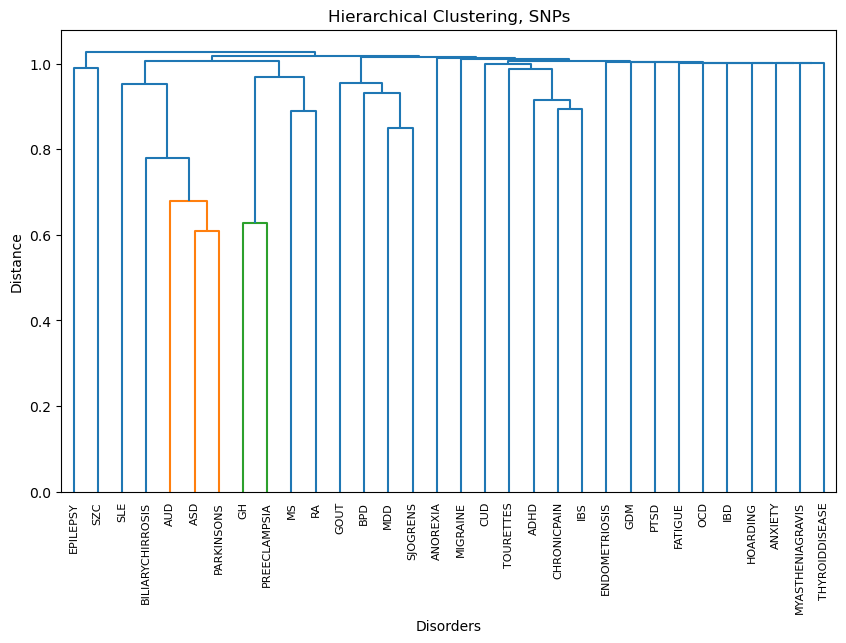

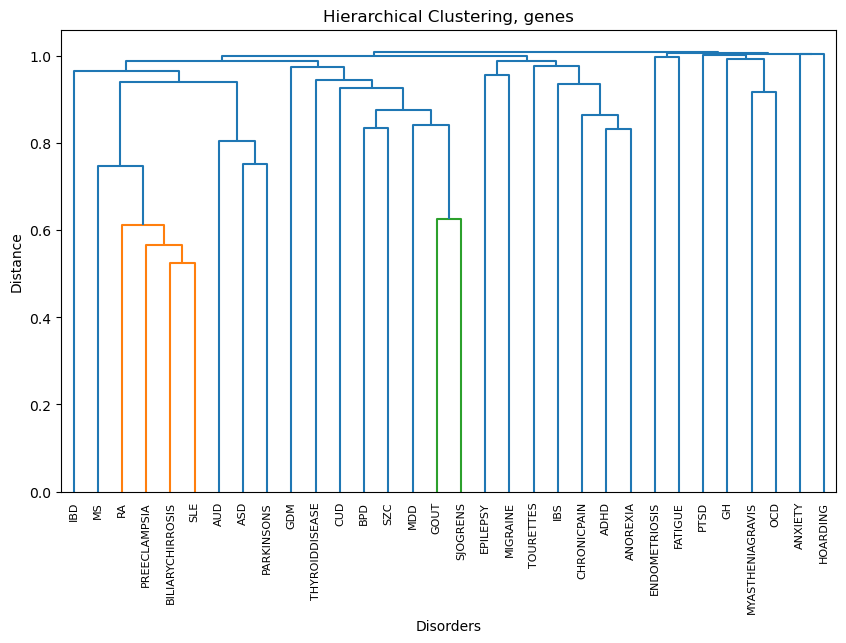

In [304]:
hierarchical_clustering(all_snps_binary, 'SNPs')
hierarchical_clustering(all_genes_binary, 'genes')

In [292]:
# select top 500 SNPs/genes ranked by significance
top_snp_list = []
top_gene_list = []

for df in snp2eqtl_dfs:
    # Sort by 'gwasP'
    sorted_df = df.sort_values(by=['gwasP'])
    
    # Get top 500 unique SNPs 
    top_snps = sorted_df.drop_duplicates(subset='rsID').iloc[:500]
    top_snps.reset_index(drop=True, inplace=True)
    top_snp_list.append(top_snps)
    
    # Get top 500 unique genes 
    top_genes = sorted_df.drop_duplicates(subset='symbol').iloc[:500]
    top_genes.reset_index(drop=True, inplace=True)
    top_gene_list.append(top_genes)

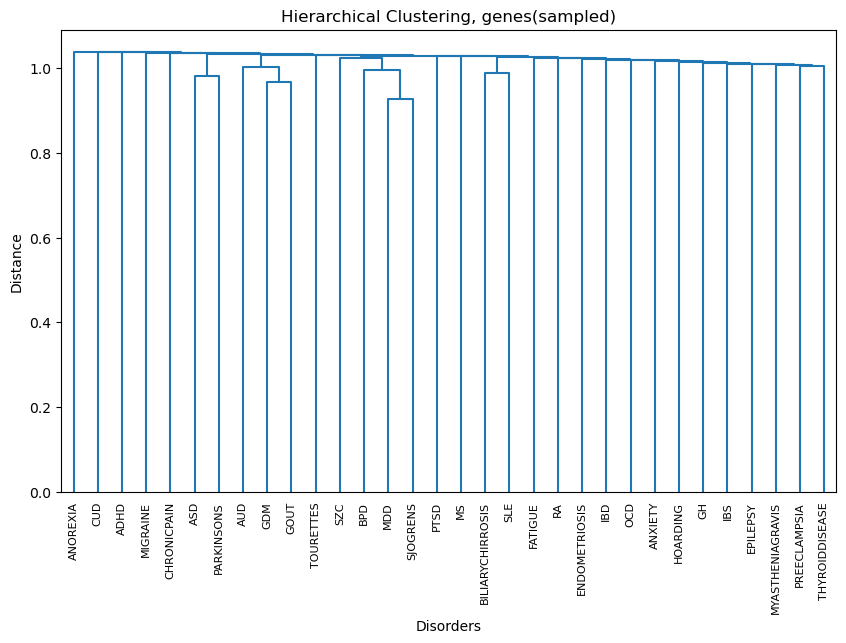

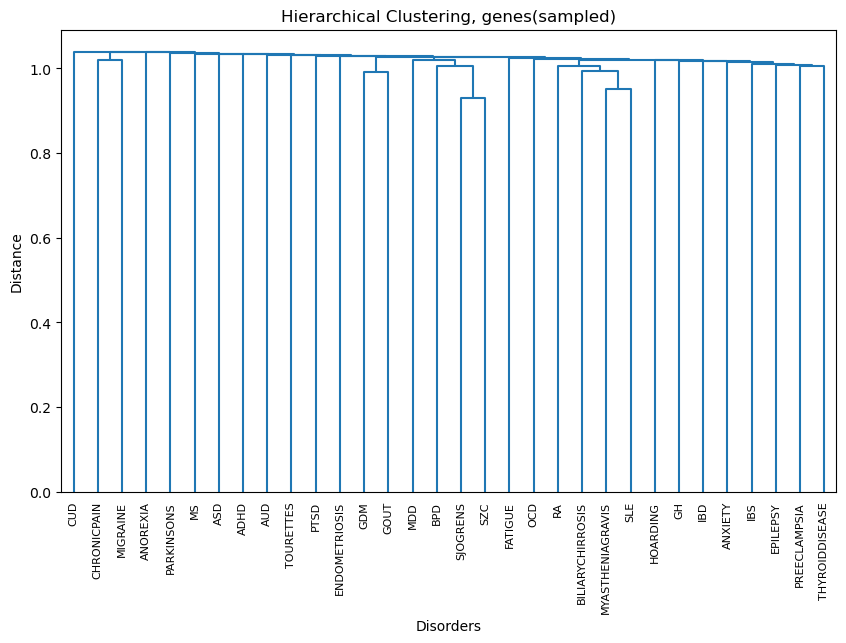

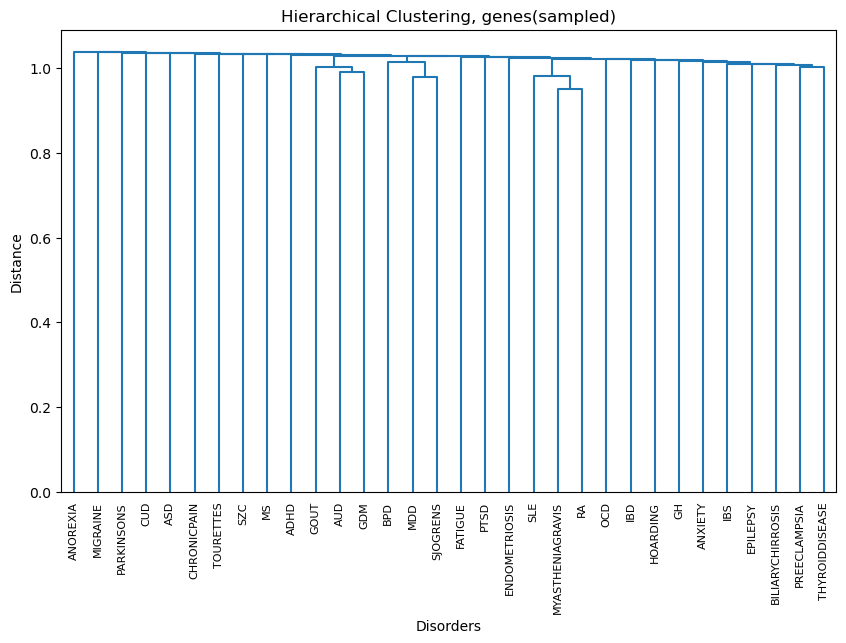

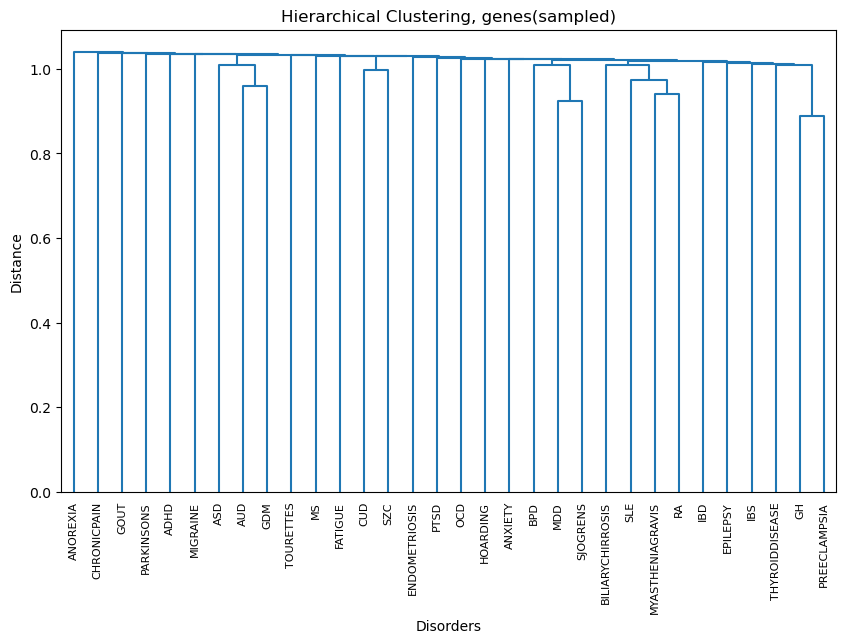

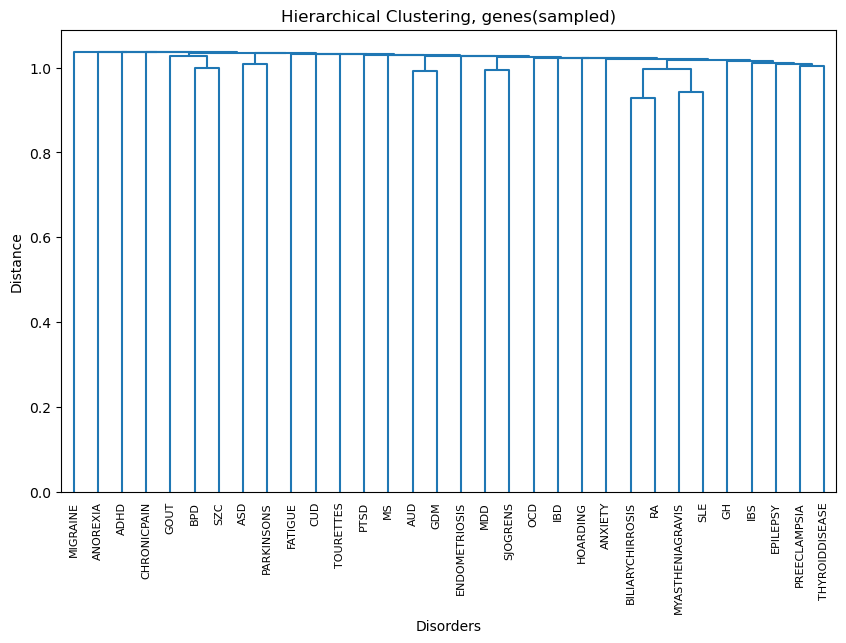

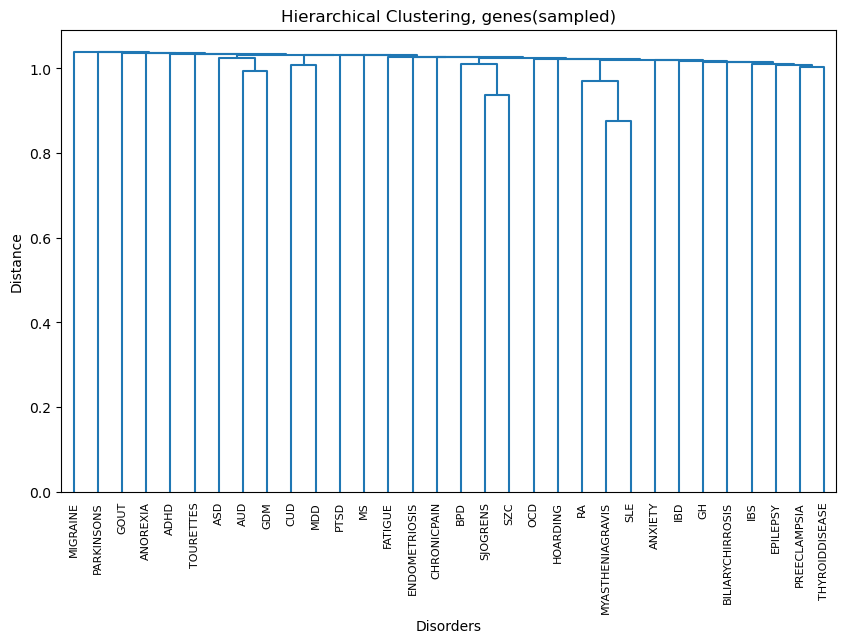

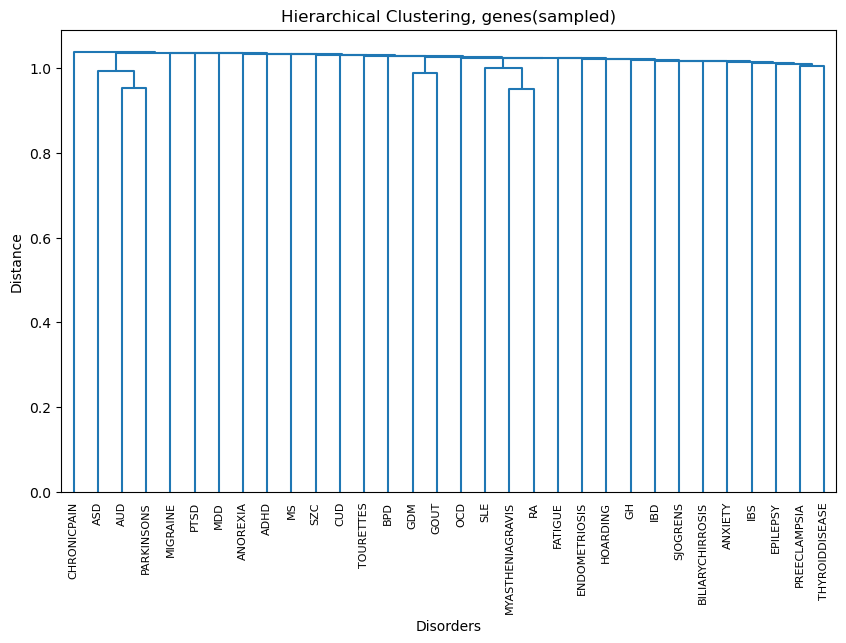

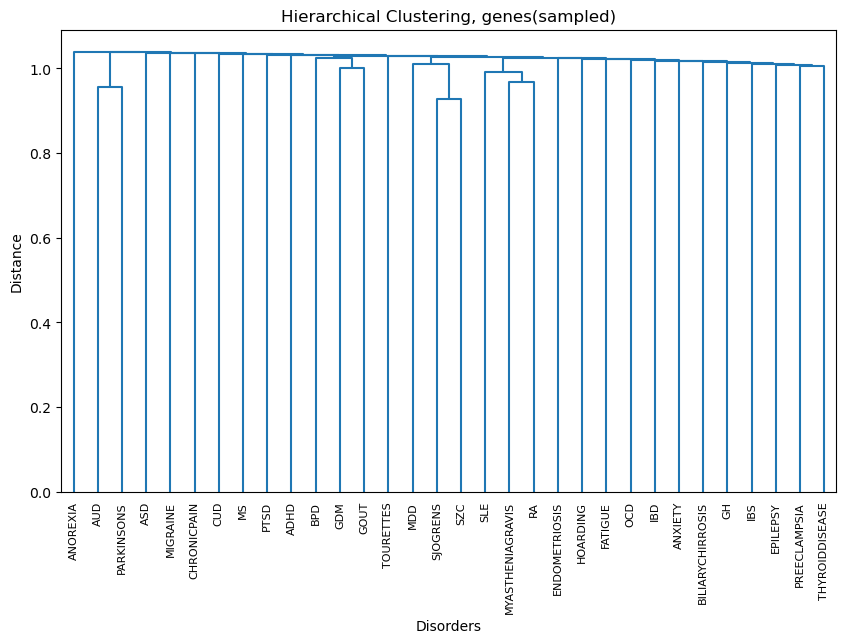

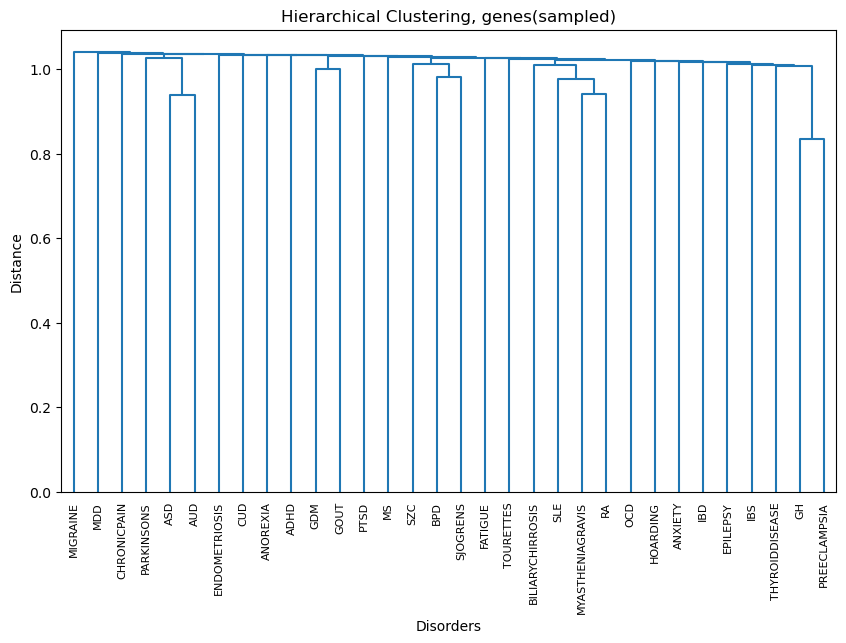

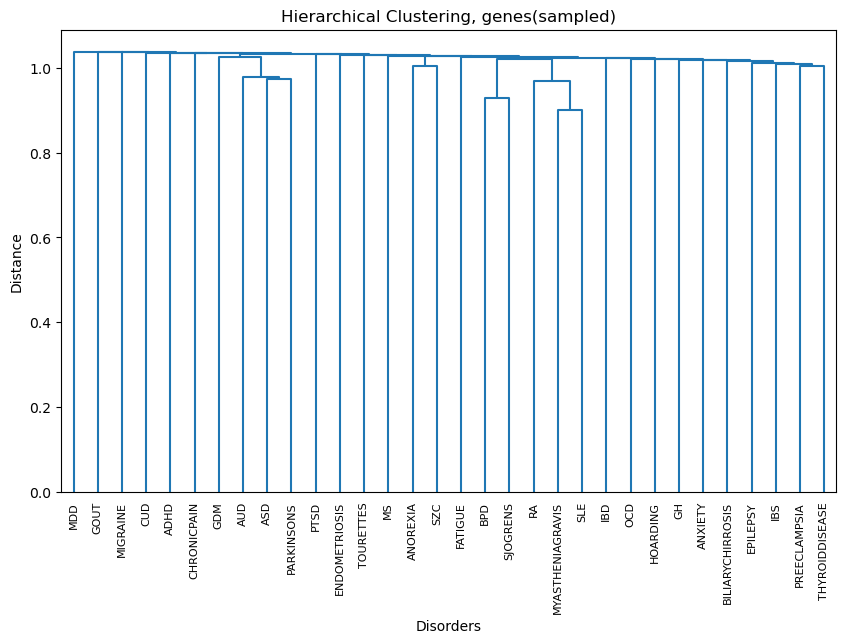

" # Compute the mean linkage matrix\nmean_linkage = np.mean(all_linkage, axis=0)\n# Plot the dendrogram for the mean linkage matrix\nplt.figure(figsize=(10, 6))\ndendrogram = hierarchy.dendrogram(mean_linkage)\nplt.xlabel('Disorders')\nplt.ylabel('Distance')\nplt.title('Consensus Hierarchical Clustering Dendrogram')\nplt.xticks(rotation=90)\nplt.show() "

In [312]:
all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(10):
    sampled_dfs = []
    for df in top_gene_list:
        sampled = df.sample(40, axis=0, replace=True)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_matrix(sampled_dfs, 'rsID', 'disease')

    #Subtract the correlation matrix to convert correlation into dissimilarity(distances)
    distance_matrix = 1 - sampled_binary.corr()

    # Convert the distance matrix to a condensed form
    condensed_distance = hierarchy.distance.squareform(distance_matrix)

    # Compute the linkage matrix
    link = hierarchy.linkage(condensed_distance, method='average')

    all_linkage.append(link)

    # Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(link, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering, genes(sampled)')
    plt.xticks(rotation=90)
    plt.show()

""" # Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show() """

In [ ]:
#  randomly select a given number of SNPs

all_linkage = []

# Perform hierarchical clustering 10 times and store the linkage matrices
for _ in range(10):
    sampled_dfs = []
    for df in top_gene_list:
        sampled = df.sample(40, axis=0, replace=True)
        sampled.reset_index(inplace=True, drop=True)
        sampled_dfs.append(sampled)

    sampled_binary = make_binary_matrix(sampled_dfs, 'rsID', 'disease')
    

    # Hierarchical clustering
    linkage_matrix = hierarchy.linkage(sampled_binary.T, method='average')
    all_linkage.append(linkage_matrix)

# Plot the dendrogram
    plt.figure(figsize=(10, 6))
    dendrogram = hierarchy.dendrogram(linkage_matrix, labels=sampled_binary.columns)
    plt.xlabel('Disorders')
    plt.ylabel('Distance')
    plt.title('Hierarchical Clustering, genes (sampled)')
    plt.xticks(rotation=90)
    plt.show()  

# Compute the mean linkage matrix
mean_linkage = np.mean(all_linkage, axis=0)
print(mean_linkage)
# Plot the dendrogram for the mean linkage matrix
plt.figure(figsize=(10, 6))
dendrogram = hierarchy.dendrogram(mean_linkage)
plt.xlabel('Disorders')
plt.ylabel('Distance')
plt.title('Consensus Hierarchical Clustering Dendrogram')
plt.xticks(rotation=90)
plt.show()

In [ ]:
#function to find the overlaps in SNPs and genes

def find_overlaps(binary_matrix, disorders_of_interest):
    overlaps = []
    overlapping_genes = set()

    for index, row in binary_matrix.iterrows():
        ones = {col for col, val in row.items() if val == 1 and col in disorders_of_interest}

        if ones and ones == set(disorders_of_interest):
            overlaps.append((index, ones))
            overlapping_genes.add(index)

    return overlaps, list(overlapping_genes) 


In [ ]:
dis_of_int = ['SZC','BPD']
overlapping_genes, gene_list = find_overlaps(all_genes_binary, dis_of_int)
#overlapping_snps = find_overlaps(all_snps_binary)

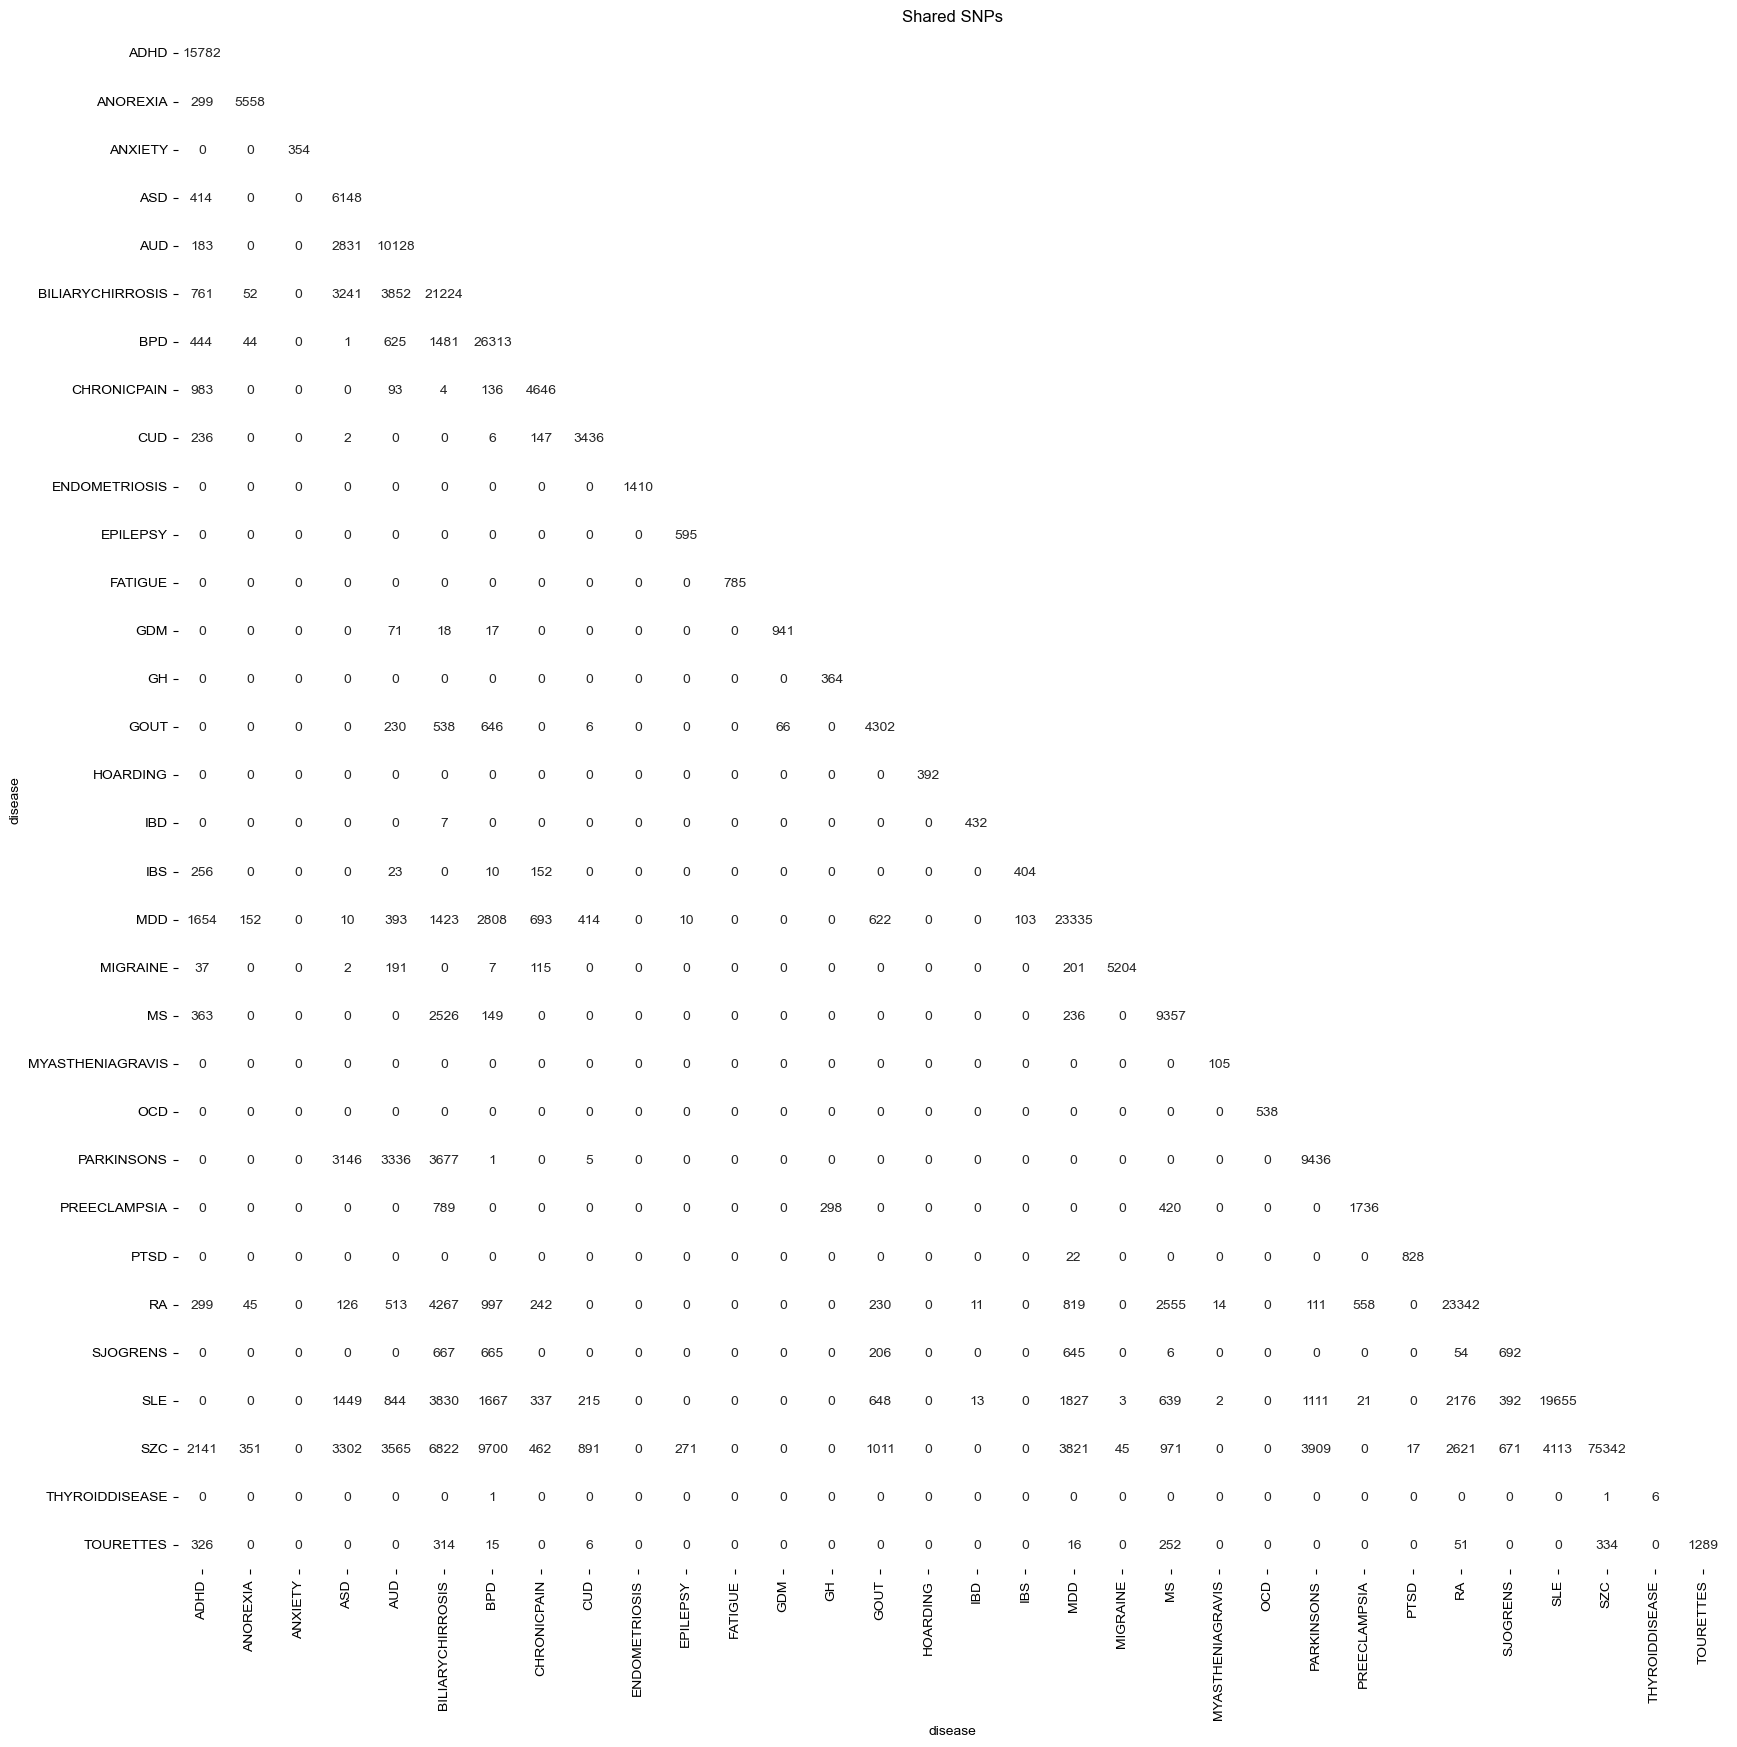

In [9]:
shared_snps = pd.DataFrame(index=all_snps_binary.columns, columns=all_snps_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_snps_binary.columns:
    for disorder2 in all_snps_binary.columns:
        count=sum(all_snps_binary[disorder1] & all_snps_binary[disorder2])
        shared_snps.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_snps_binary.columns:
    total_count = all_snps_binary[disorder].sum()
    shared_snps.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders_snps = shared_snps.columns.tolist()
disorder_matrix_snps = shared_snps.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_snps), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_snps[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20, 20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_snps, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared SNPs')
    plt.show()

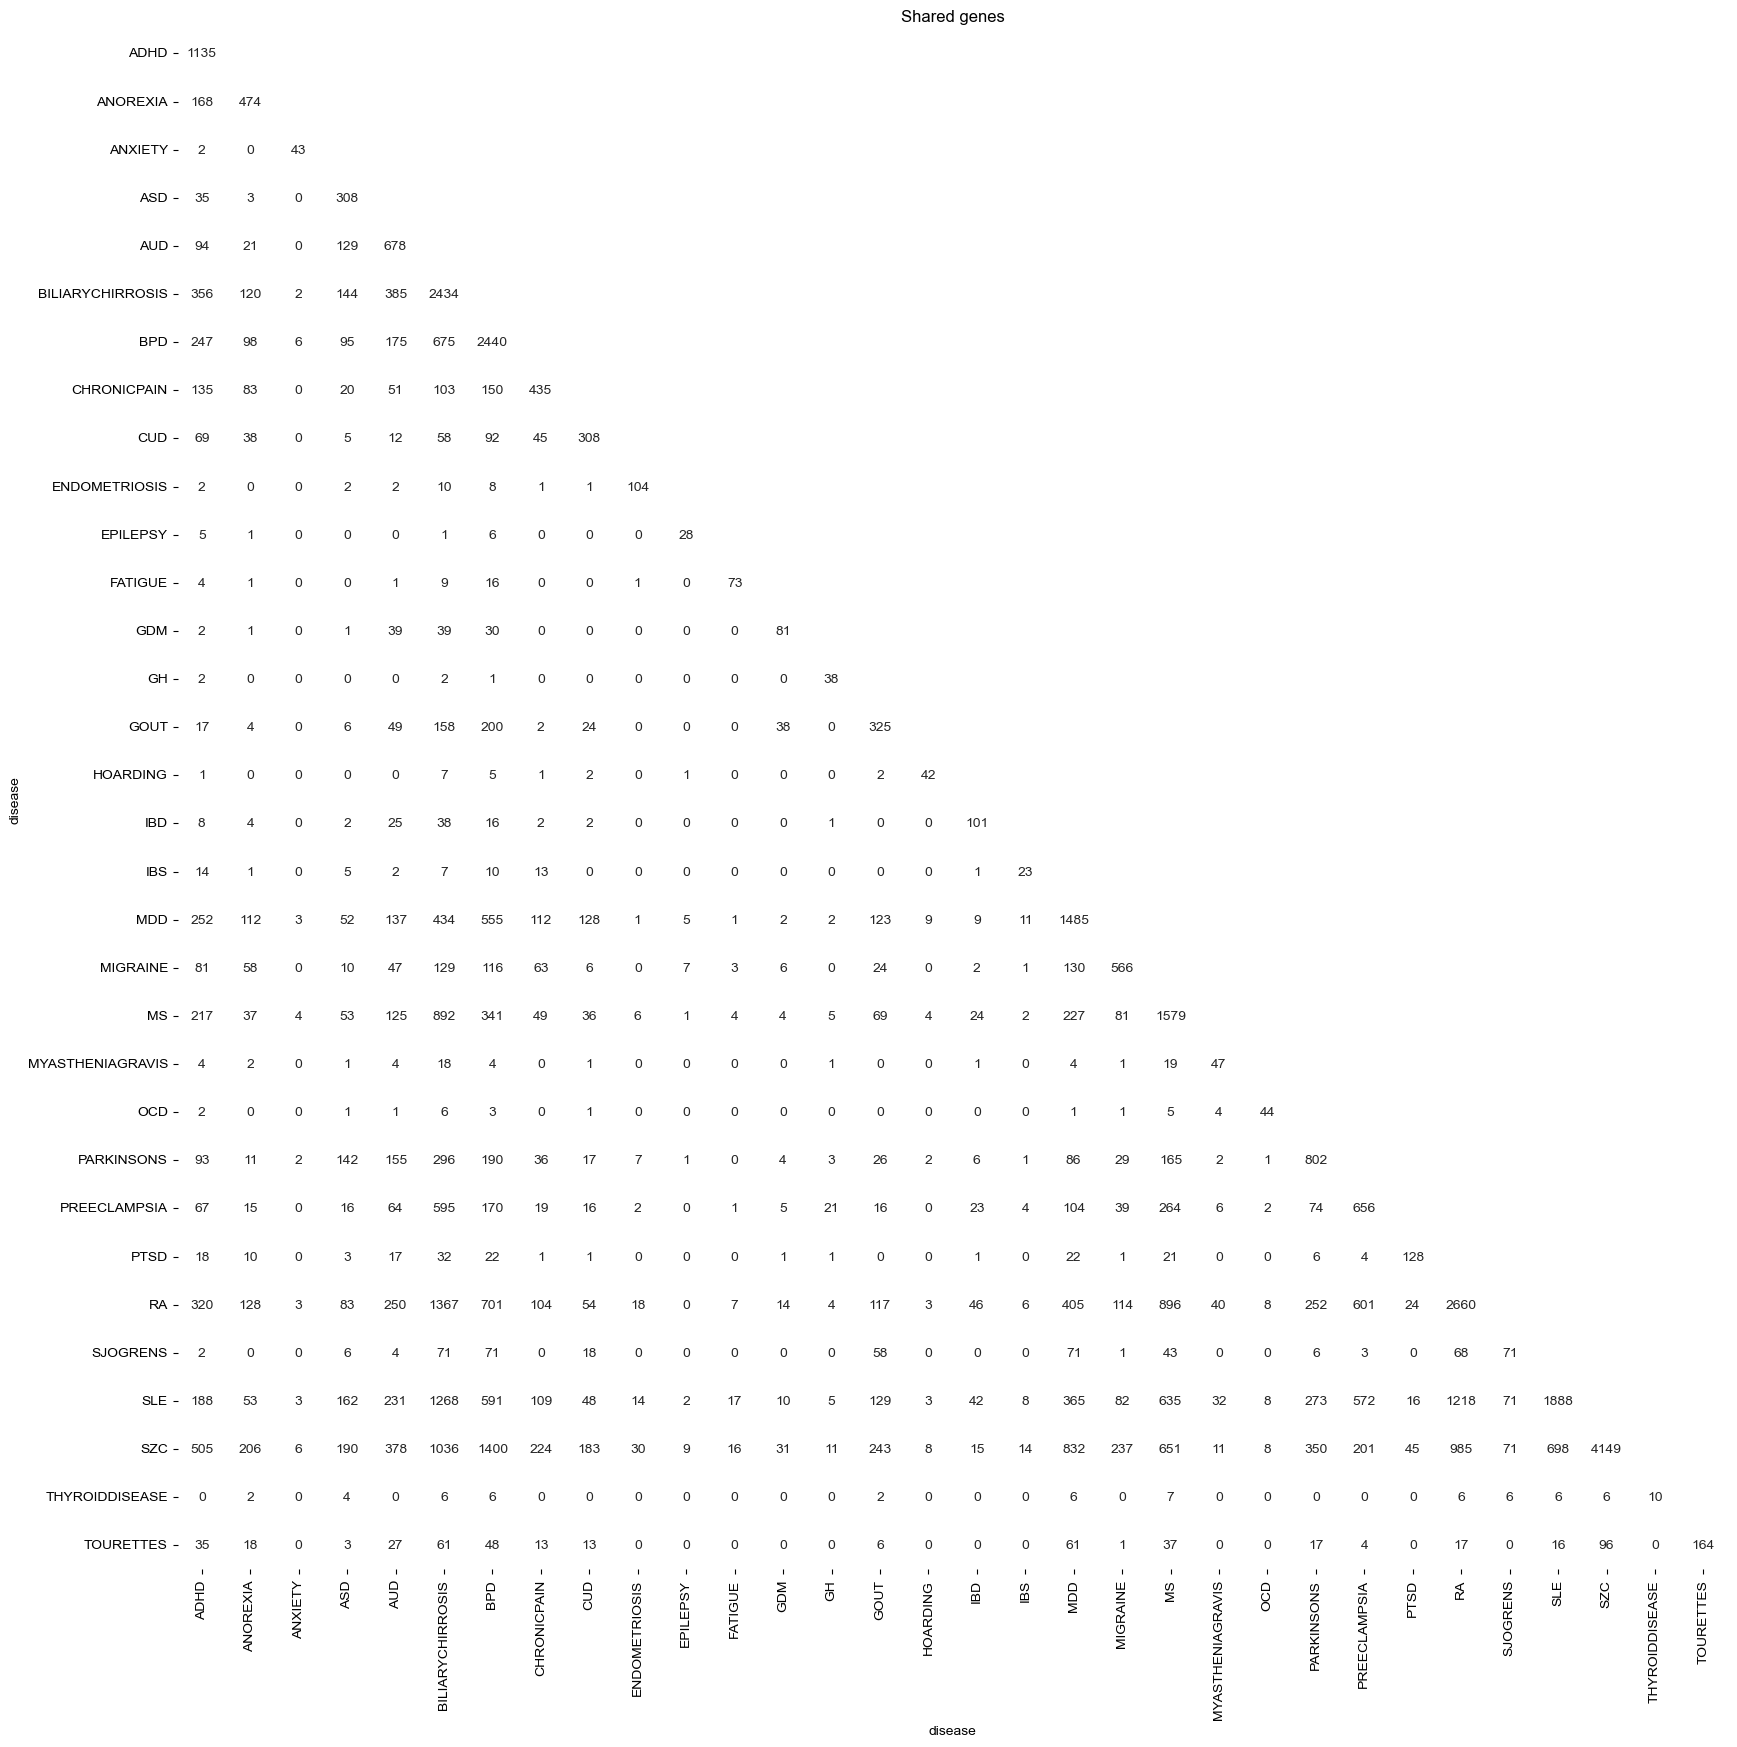

In [10]:
shared_genes = pd.DataFrame(index=all_genes_binary.columns, columns=all_genes_binary.columns, dtype=int)

#Iterate through all pairs of disorders and count genes shared
for disorder1 in all_genes_binary.columns:
    for disorder2 in all_genes_binary.columns:
        count=sum(all_genes_binary[disorder1] & all_genes_binary[disorder2])
        shared_genes.at[disorder1,disorder2] = count

#Add total number of genes in each disorder on the diagonal
for disorder in all_genes_binary.columns:
    total_count = all_genes_binary[disorder].sum()
    shared_genes.at[disorder, disorder] = total_count

#get lower triangular matrix including the diagonal
#shared_lower = pd.DataFrame(np.tril(shared_genes), index=genes_binary.columns, columns=genes_binary.columns)
disorders = shared_genes.columns.tolist()
disorder_matrix = shared_genes.to_numpy()

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(shared_genes), k=1).astype(bool)

# Set the values in the upper triangular part to NaN
shared_genes[mask] = np.nan

# Specify the size of the heatmap
fig, ax = plt.subplots(figsize=(20,20))

# Plot the heatmap
with sns.axes_style('white'):
    sns.heatmap(shared_genes, annot=True, fmt='.0f', cmap=ListedColormap(['white']), cbar=False)
    plt.title('Shared genes')
    plt.show()

In [11]:

def hypergeometric_prob(matrix, disorder_list, M):

    matrix_shape= matrix.shape
    prob_matrix = np.zeros(matrix_shape)

    for i in range(1, matrix_shape[0]):
        for j in range(i):
            x =matrix[i,j]
            n = matrix[j,j]
            N = matrix[i, i]
            #print(M,n,x)
            
            prob = hypergeom.sf(x-1, M, n, N)
            
                
            prob_matrix[i,j] = prob

    return pd.DataFrame(prob_matrix, columns=disorder_list, index=disorder_list)

   

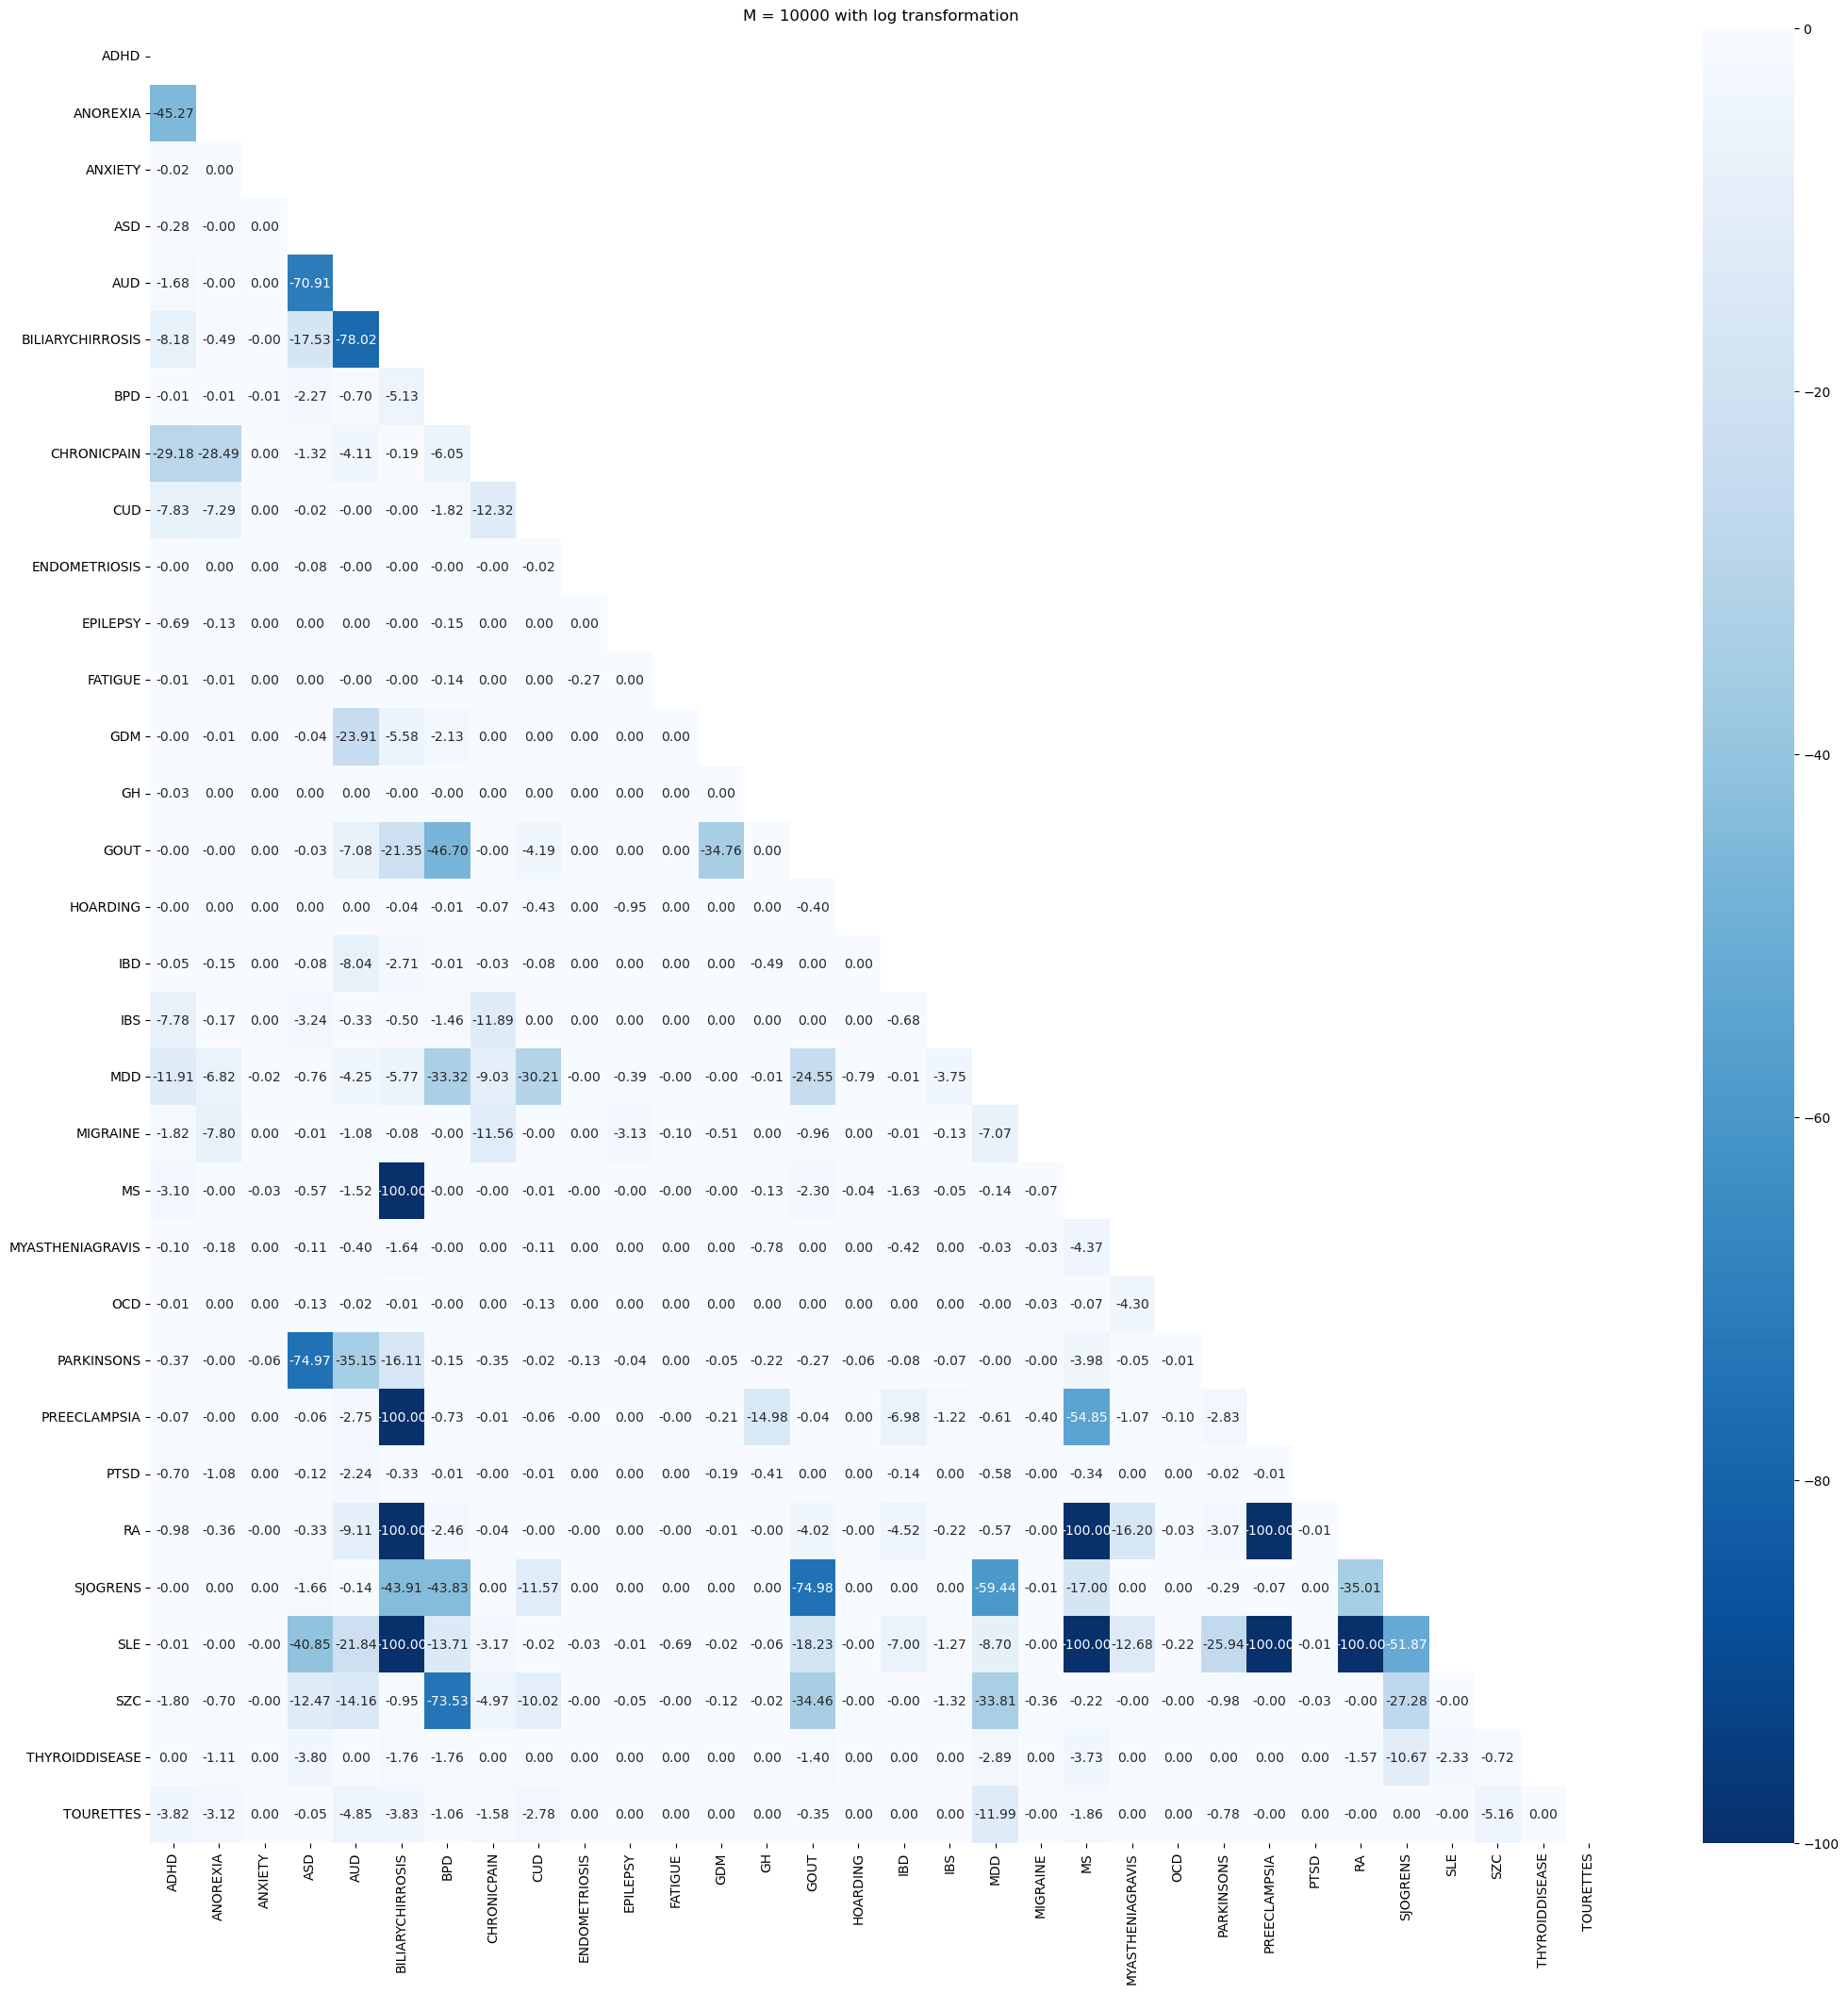

<Figure size 2500x2500 with 0 Axes>

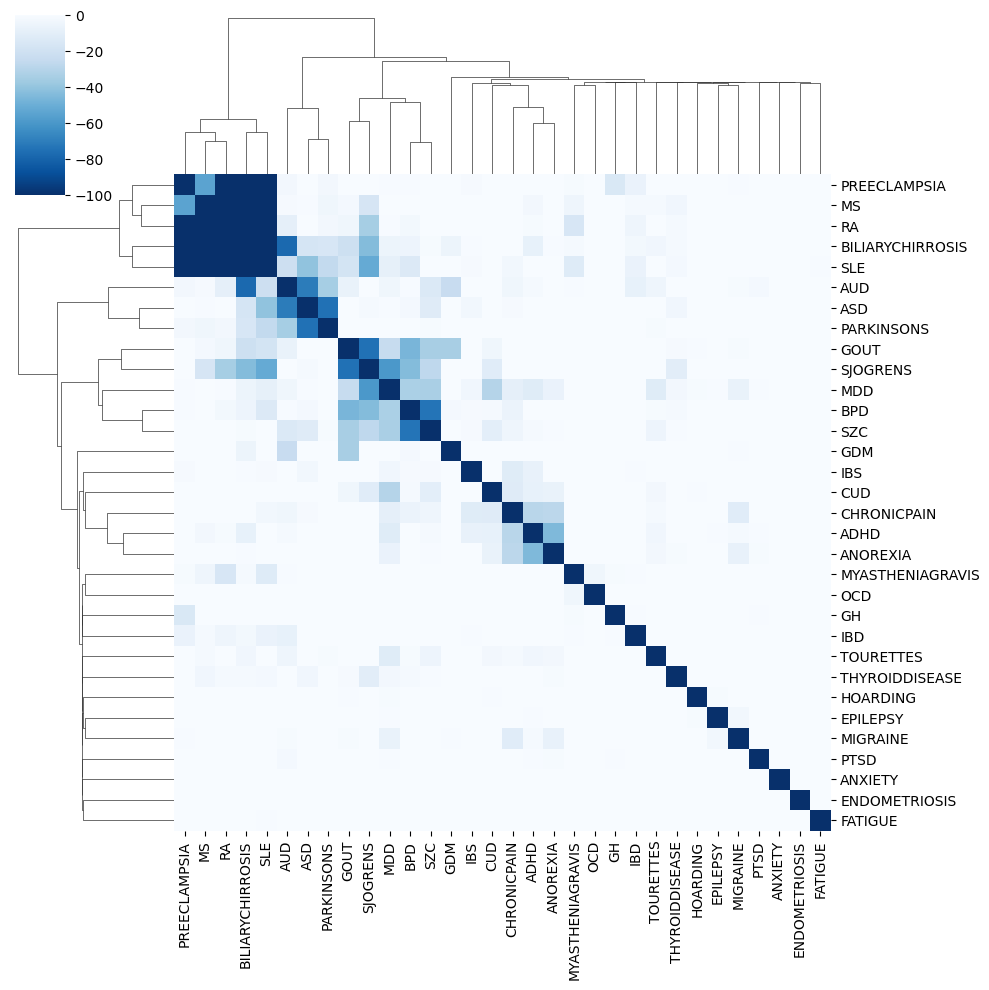

In [12]:
prob_genes_10K=hypergeometric_prob(disorder_matrix, disorders, 10000)
    
# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(prob_genes_10K, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
prob_genes_10K = prob_genes_10K.mask(mask)

#Apply log transformation to avoid taking log of 0
prob_genes_10K_log = np.log10(prob_genes_10K+1e-100)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,25))
plt.title('M = 10000 with log transformation')
sns.heatmap(prob_genes_10K_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

prob_genes_10Kfull_matrix = np.tril(prob_genes_10K) + np.tril(prob_genes_10K, -1).T

prob_genes_10Kfull_df = pd.DataFrame(prob_genes_10Kfull_matrix, index=disorders, columns=disorders)
prob_genes_10Kfull_df = prob_genes_10Kfull_df.fillna(1e-100)
prob_genes_10Kfull_df_log = np.log10(prob_genes_10Kfull_df + 1e-100)

plt.figure(figsize=(25,25))
sns.clustermap(prob_genes_10Kfull_df_log,cmap=cmap_reversed)

plt.show()

    
    

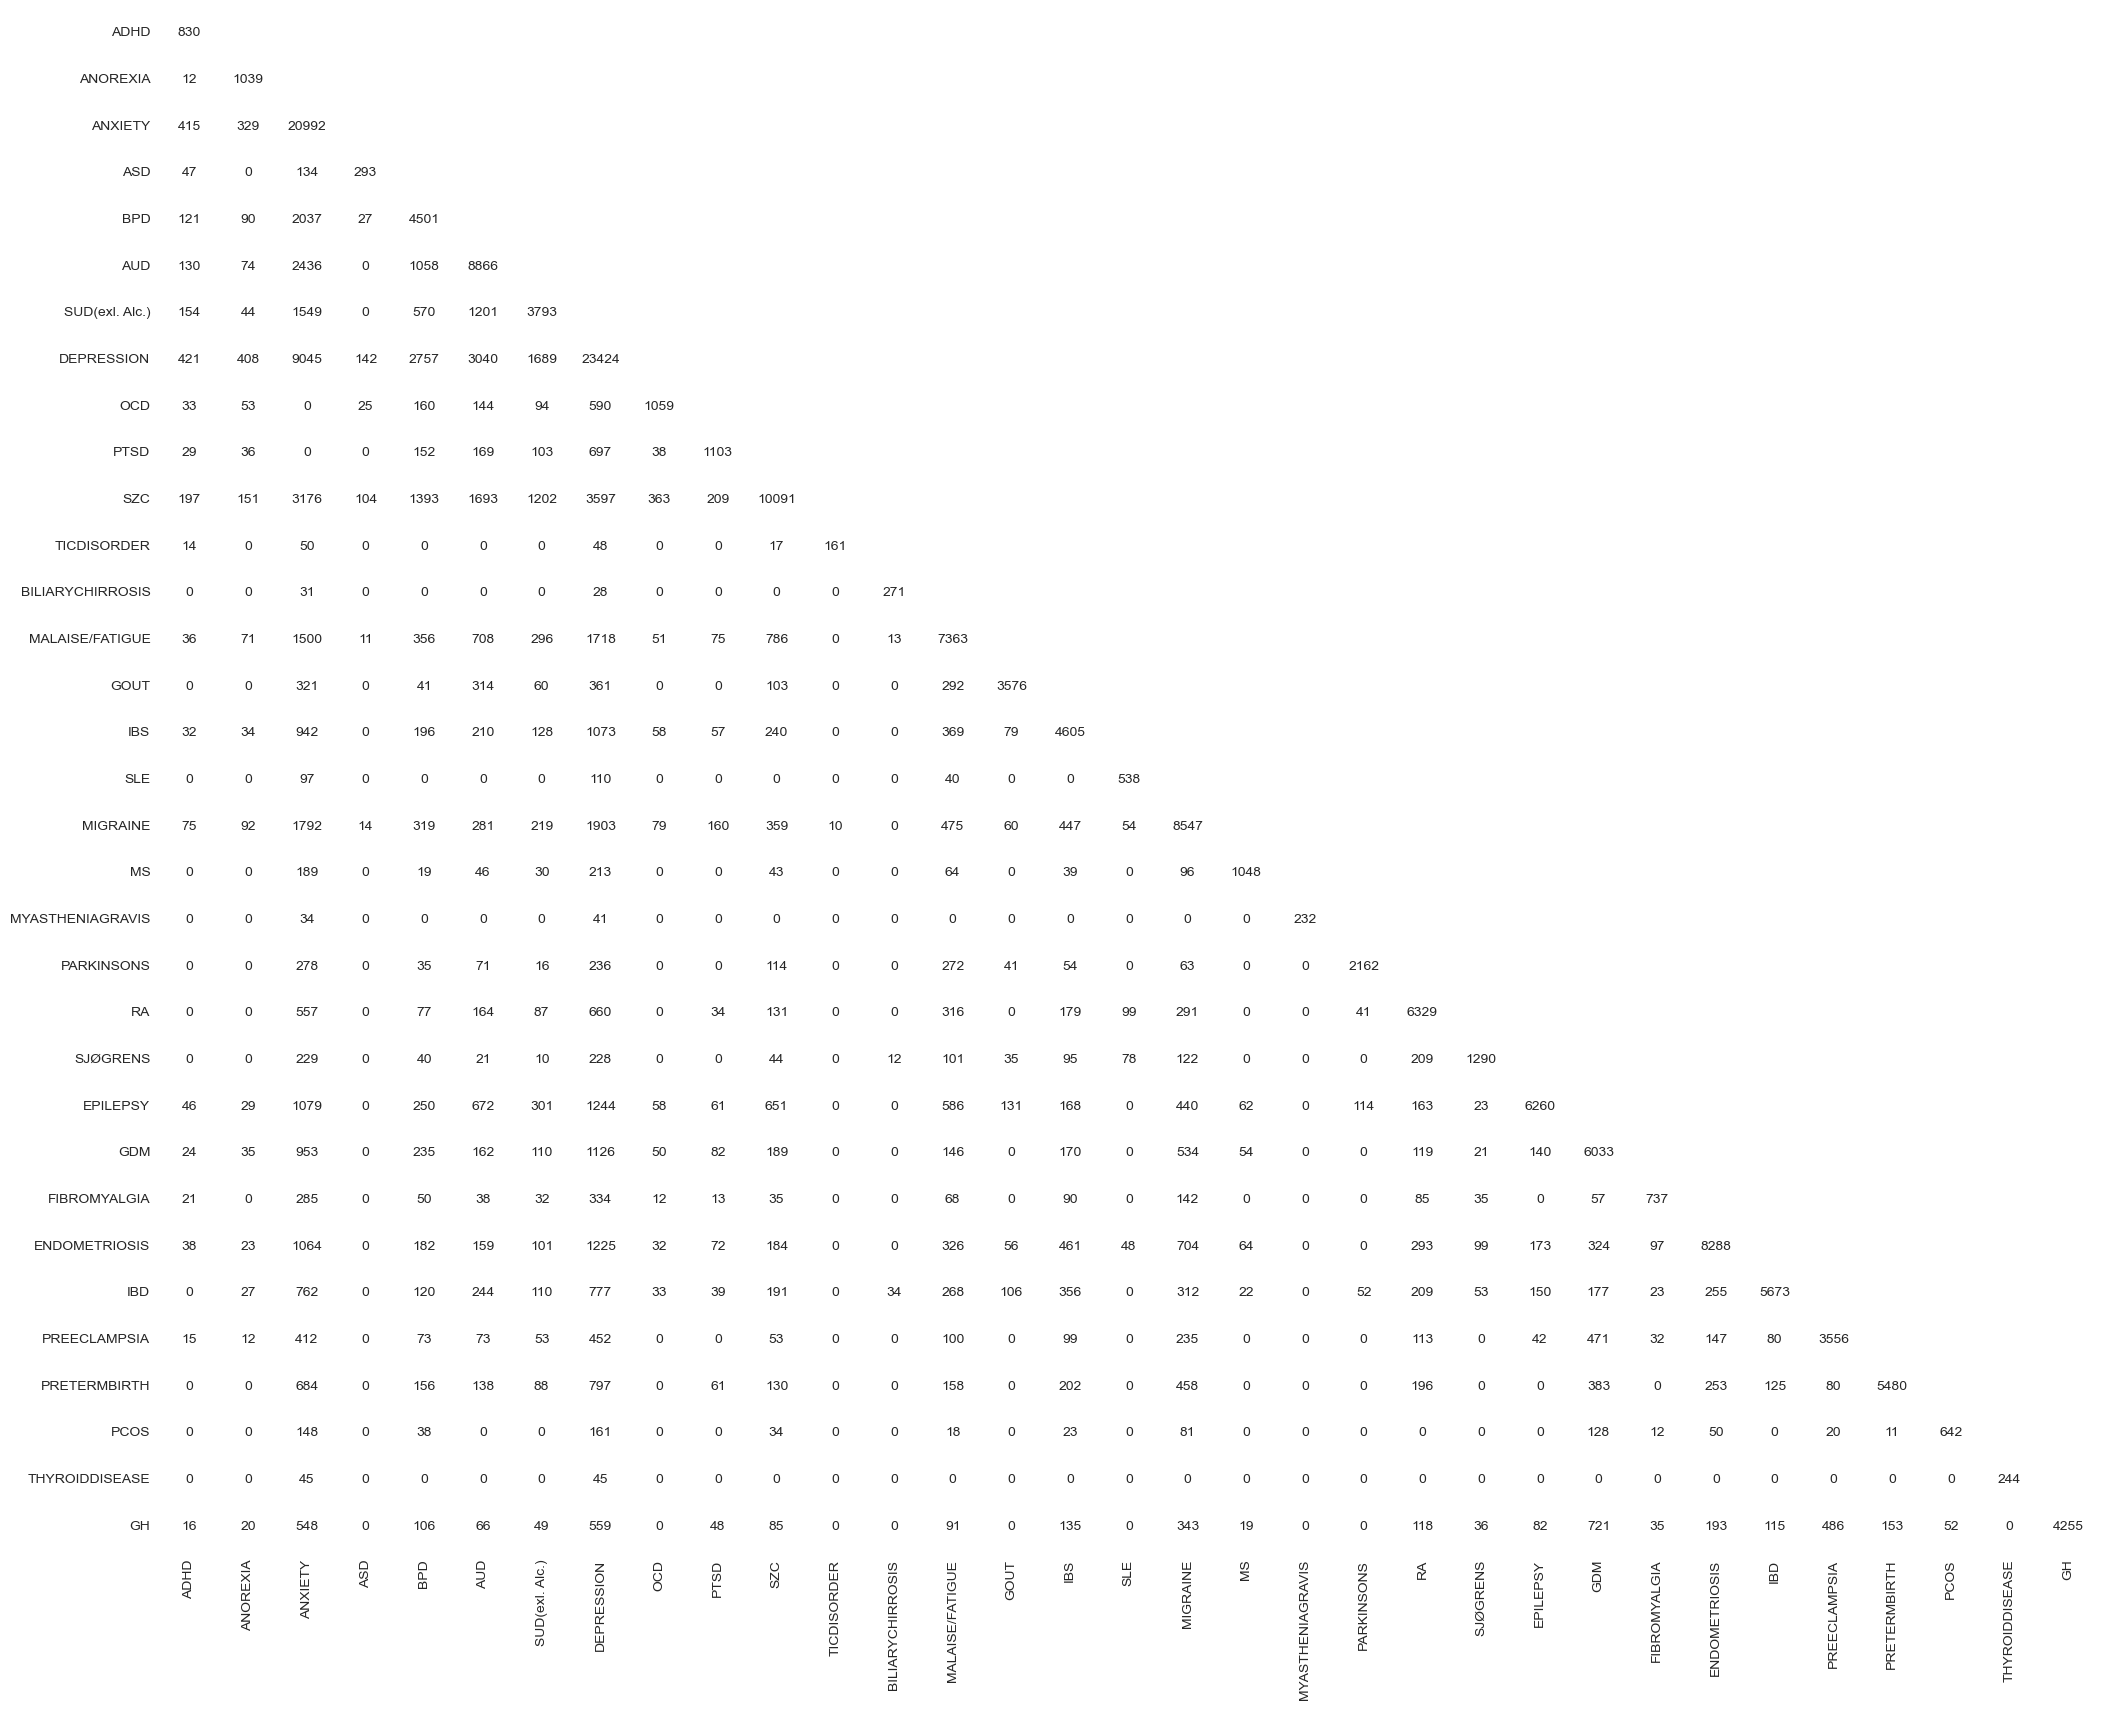

In [13]:
finngen = pd.read_csv('FinnGen/FinnGen_table_all_diseases.csv', sep=';', index_col=0)
disorder_list = finngen.index.values.tolist()
fin_matrix = finngen.to_numpy()
full_finngen_matrix2 = np.tril(finngen) + np.tril(finngen, -1).T
finngen2 = pd.DataFrame(full_finngen_matrix2, index=disorder_list, columns=disorder_list)

# Create a mask for the diagonal
diagonal_mask = np.eye(len(finngen2), dtype=bool)
mask = np.triu(np.ones_like(finngen2, dtype=bool), k=1)

plt.figure(figsize=(25,20))
with sns.axes_style('white'):
    sns.heatmap(finngen2,cmap=ListedColormap(['white']), annot=True, fmt='.0f', mask=mask, cbar=False)
    plt.show()

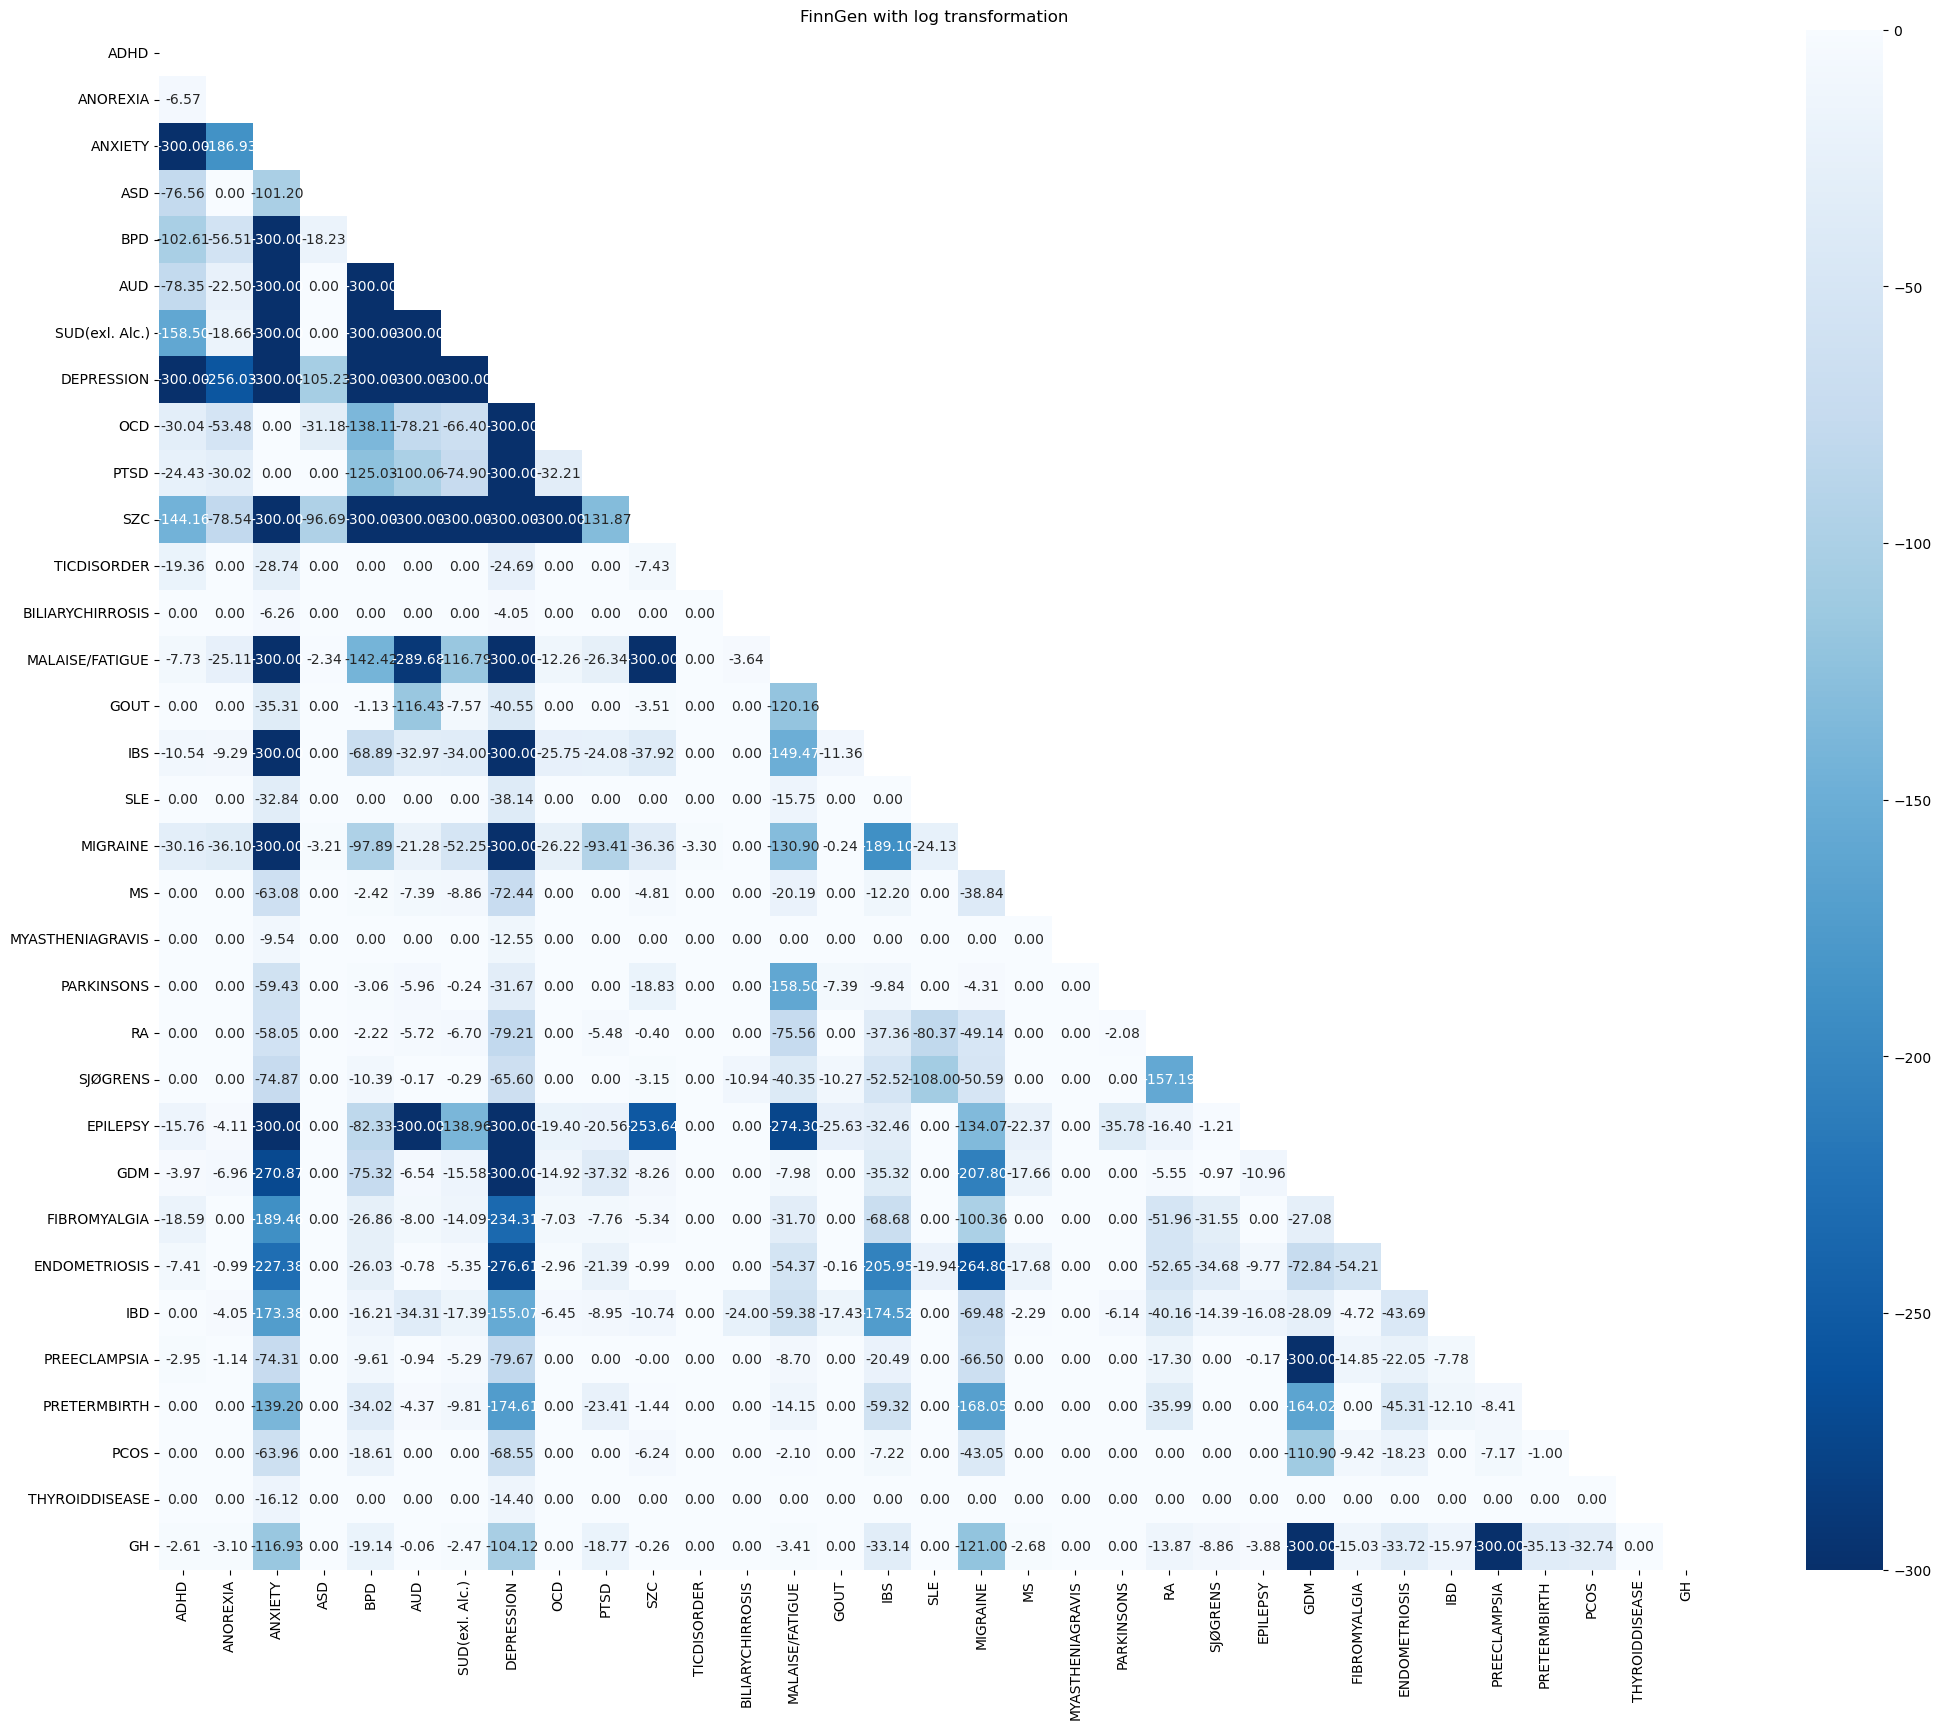

<Figure size 2000x1500 with 0 Axes>

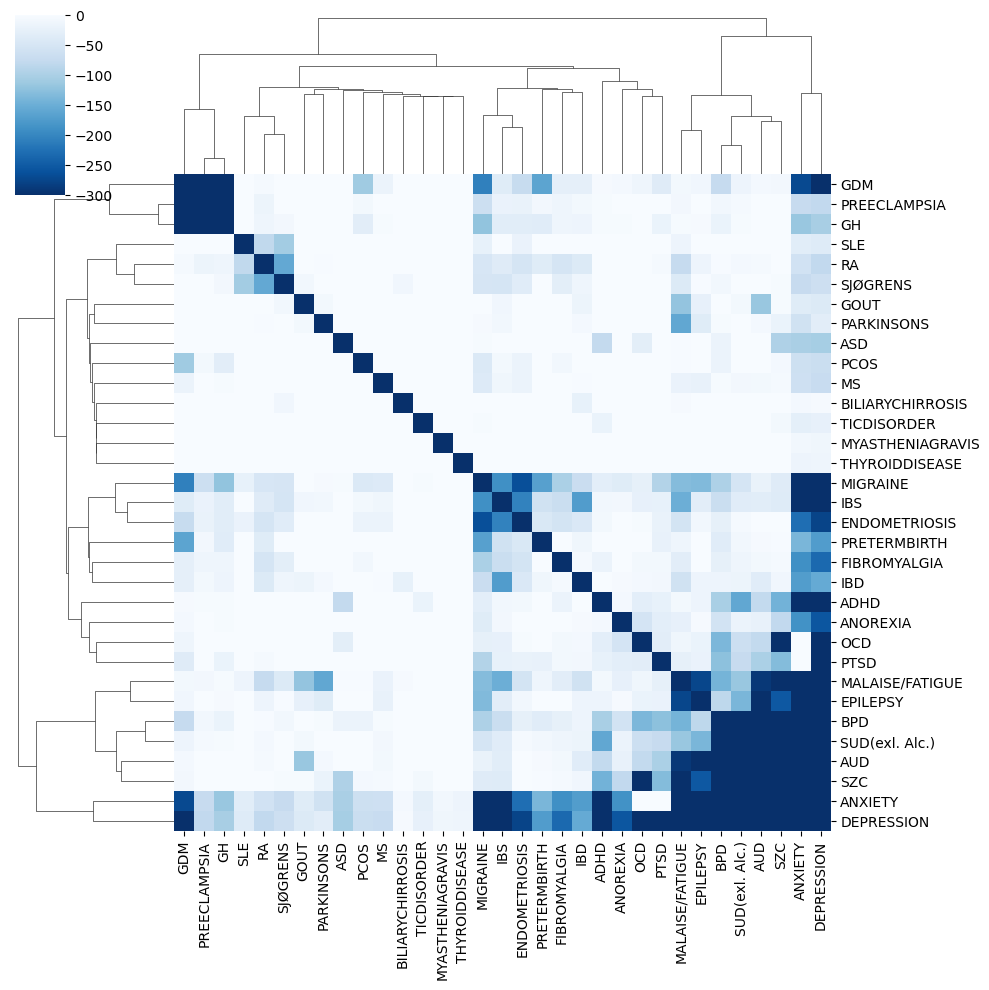

In [178]:
finngen_p = hypergeometric_prob(fin_matrix,disorder_list, 500000)

# Create a mask for the upper triangular part
mask = np.triu(np.ones_like(finngen_p, dtype=bool))

# Set the upper triangular part to NaN to exclude it from the plot
finngen_p = finngen_p.mask(mask)

#Apply log transformation to avoid taking the log of 0
finngen_log = np.log10(finngen_p+1e-300)

#reverse colormap
cmap = 'Blues'
cmap_reversed = cmap + '_r'

fig, ax = plt.subplots(figsize=(25,20))
plt.title('FinnGen with log transformation')
sns.heatmap(finngen_log, annot=True,fmt='.2f',cmap=cmap_reversed, cbar=True)

full_finngen_matrix = np.tril(finngen_p) + np.tril(finngen_p, -1).T
full_finngen_df = pd.DataFrame(full_finngen_matrix, index=disorder_list, columns=disorder_list)
full_finngen_df = full_finngen_df.fillna(1e-300)
full_finngen_log = np.log10(full_finngen_df+1e-300)
plt.figure(figsize=(20,15))
sns.clustermap(full_finngen_log,cmap=cmap_reversed)
plt.show()


In [15]:
# Create a graph from the PPI network
biogrid = pd.read_csv('BIOGRID2.tab.txt', sep='\t')

G = nx.Graph()

for index, row in biogrid.iterrows():
    source_node = row['OFFICIAL_SYMBOL_A']
    target_node = row['OFFICIAL_SYMBOL_B']
       
    G.add_edge(source_node, target_node)

In [265]:
for df in snp2eqtl_dfs:
        disease_list = ['PREECLAMPSIA']
        disease = df.iloc[0]['disease']
        if disease in disease_list:
        
            subset_of_nodes = df['symbol'].drop_duplicates().tolist()

            #subset_of_nodes = subset_of_nodes[:100]

            # Create a new graph to store the shortest paths
            H = nx.Graph()

            # Find the shortest path between each pair of nodes in the subset
            for i in range(len(subset_of_nodes)):
                for j in range(i + 1, len(subset_of_nodes)):
                    node_i = subset_of_nodes[i]
                    node_j = subset_of_nodes[j]
                    
                    # Check if both nodes exist in graph G
                    if node_i in G and node_j in G:
                        try:
                            # Calculate shortest path if nodes exist in G
                            path = nx.shortest_path(G, node_i, node_j)
                            if len(path) <= 3: # the number refers to nodes, not edges
                                
                                path_edges = [(path[k], path[k+1]) for k in range(len(path)-1)]
                                #print(len(path), path, path_edges)
                                H.add_edges_from(path_edges)
                        except nx.NetworkXNoPath:
                            continue
                    else:
                        continue

            # Find the minimum spanning tree of the new graph
            mst = nx.minimum_spanning_tree(H, algorithm='kruskal')


            degree_g = dict(G.degree())

            degree_mst = dict(mst.degree())

            degree_df = pd.DataFrame({'Gene': list(G.nodes), 
                                    'Deg(G)': [degree_g[node] for node in G.nodes()],
                                    'Deg(MST)': [degree_mst[node] if node in degree_mst else 0 for node in G.nodes()],
                                    '% (deg(MST)/deg(G))': [(degree_mst[node] / degree_g[node]) * 100 if node in degree_mst and degree_g[node] != 0 else 0 for node in G.nodes()]}).round(2).sort_values(by='% (deg(MST)/deg(G))', ascending=False)

            

            # Get top 20 nodes with the highest percentage from degree_df
            top_nodes = degree_df[degree_df['Deg(G)'] >= 10].nlargest(20, '% (deg(MST)/deg(G))')
            print('top nodes ok')
            print(top_nodes)

            # Create a color map for the nodes
            node_color_map = []
            for node in G.nodes():
                if node in top_nodes['Gene'].values:
                    if node in subset_of_nodes:
                        node_color_map.append('blue')
                    else:
                        node_color_map.append('green')
                else:
                    node_color_map.append('grey')
            print('color map ok')

            # Create a size map for the nodes
            node_size_map = []
            for node in G.nodes():
                if node in top_nodes['Gene'].values:
                    node_size_map.append(300)
                else:
                    node_size_map.append(50)

            print('size map ok')

            # Create the plot
            plt.figure(figsize=(12, 12))
            pos = nx.spring_layout(G)  # positions for all nodes

            # Draw the entire graph in the background
            nx.draw_networkx_edges(G, pos, alpha=0.2)
            nx.draw_networkx_nodes(G, pos, node_size=node_size_map, node_color=node_color_map, alpha=0.6)

            # Draw node labels for the top nodes
            top_node_labels = {node: node for node in top_nodes['Gene'].values}
            nx.draw_networkx_labels(G, pos, labels=top_node_labels, font_size=8, font_color='black')

            # Show the plot
            plt.title(f"Graph Visualization with Highlighted Top 20 Nodes, {disease}")
            plt.show()



top nodes ok
            Gene  Deg(G)  Deg(MST)  % (deg(MST)/deg(G))
4608    TNFRSF17      22        18                81.82
6330       PRKG2      10         8                80.00
4949       ALDH2     130        92                70.77
16293     HECTD4      30        21                70.00
5973       NR1H3      52        35                67.31
9946       RCAN3      17         9                52.94
1816       RIPK2      80        42                52.50
8457      COBLL1      62        32                51.61
1211      CLUAP1     227       112                49.34
4916       RAP2A      77        37                48.05
4293       IL2RB      25        12                48.00
4168      DYRK1B      87        41                47.13
1131       PRPF6     304       142                46.71
15231   TMEM106B     307       140                45.60
5696   TNFRSF13B      44        20                45.45
7474     RHOBTB3      91        40                43.96
10311   C12orf75      23        10 

KeyboardInterrupt: 

<Figure size 1200x1200 with 0 Axes>

In [261]:
degree_df.to_csv('preeclampsia_degree.txt', sep='\t', index=False)

In [94]:
for df in snp2eqtl_dfs:
        disease = df.iloc[0]['disease']
        
        subset_of_nodes = df['symbol'].drop_duplicates().tolist()

        # Create a new graph to store the shortest paths
        H = nx.Graph()

        # Find the shortest path between each pair of nodes in the subset
        for i in range(len(subset_of_nodes)):
            for j in range(i + 1, len(subset_of_nodes)):
                node_i = subset_of_nodes[i]
                node_j = subset_of_nodes[j]
                
                # Check if both nodes exist in graph G
                if node_i in G and node_j in G:
                    try:
                        # Calculate shortest path if nodes exist in G
                        path = nx.shortest_path(G, node_i, node_j)
                        if len(path) <= 4: # the number refers to number of nodes, not edges
                            path_edges = [(path[k], path[k+1]) for k in range(len(path)-1)]
                            H.add_edges_from(path_edges)
                    except nx.NetworkXNoPath:
                        continue
                else:
                    continue

        # Find the minimum spanning tree of the new graph
        mst = nx.minimum_spanning_tree(H, algorithm='kruskal')

        degree_g = dict(G.degree())
        degree_mst = dict(mst.degree())

        degree_df = pd.DataFrame({
            'Gene': list(G.nodes),
            'Deg(G)': [degree_g[node] for node in G.nodes()],
            'Deg(MST)': [degree_mst[node] if node in degree_mst else 0 for node in G.nodes()],
            '% (deg(MST)/deg(G))': [(degree_mst[node] / degree_g[node]) * 100 if node in degree_mst and degree_g[node] != 0 else 0 for node in G.nodes()],
            'Has_SNP': [node in subset_of_nodes for node in G.nodes()]  # True if the gene is in the subset, False otherwise
        }).round(2).sort_values(by='% (deg(MST)/deg(G))', ascending=False)

        # Get top 20 nodes with the highest percentage from degree_df
        top_nodes = degree_df[(degree_df['Deg(MST)'] >= 10)].nlargest(20, '% (deg(MST)/deg(G))')
        top_nodes.to_csv(f'top_nodes_{disease}.txt', sep='\t',index=False)
        #print(top_nodes)

        """ # Create a color map for nodes based on their presence in the subset
        node_color_map = []
        for node in mst.nodes():
            if node in top_nodes['Gene'].values:
                if degree_df.loc[degree_df['Gene'] == node, 'Has_SNP'].iloc[0]:
                    node_color_map.append('green')  # Node is in the subset
                else:
                    node_color_map.append('blue')  # Node is not in the subset
            else:
                node_color_map.append('lightgrey')  # Other nodes

        # Create a size map for nodes
        node_size_map = []
        for node in mst.nodes():
            if node in top_nodes['Gene'].values:
                node_size_map.append(2000)  # Larger size for top nodes
            else:
                node_size_map.append(2)  # Smaller size for other nodes

        # Create the plot
        plt.figure(figsize=(12, 12))
        pos = nx.spring_layout(mst, seed=42)  # Positions for nodes in MST. Setting seed for consistent layout

        # Draw grey nodes first
        grey_nodes = [node for node in mst.nodes() if node not in top_nodes['Gene'].values]
        grey_node_sizes = [node_size_map[list(mst.nodes()).index(node)] for node in grey_nodes]
        grey_node_colors = [node_color_map[list(mst.nodes()).index(node)] for node in grey_nodes]
        nx.draw_networkx_nodes(mst, pos, nodelist=grey_nodes, node_size=grey_node_sizes, node_color=grey_node_colors, alpha=0.6)

        # Draw green and blue nodes on top
        top_nodes_list = top_nodes['Gene'].values
        top_node_sizes = [node_size_map[list(mst.nodes()).index(node)] for node in top_nodes_list]
        top_node_colors = [node_color_map[list(mst.nodes()).index(node)] for node in top_nodes_list]
        
        nx.draw_networkx_nodes(mst, pos, nodelist=top_nodes_list, node_size=top_node_sizes, node_color=top_node_colors, alpha=0.9)

        # Draw edges
        nx.draw_networkx_edges(mst, pos, alpha=0.2)

        # Draw node labels for the top nodes
        top_node_labels = {node: node for node in top_nodes['Gene'].values}
        nx.draw_networkx_labels(mst, pos, labels=top_node_labels, font_size=10, font_color='black')
        
        # Show the plot
        plt.title(f"Minimum Spanning Tree with Top Nodes, {disease}")
        plt.show() """


In [67]:
top_nodes_all_diseases = []
for df in snp2eqtl_dfs:
    #disease_list = ['PREECLAMPSIA']
    disease = df.iloc[0]['disease']
    #if disease in disease_list:
    subset_of_nodes = df['symbol'].drop_duplicates().tolist()

    # Create a new graph to store the shortest paths
    H = nx.Graph()

    # Find the shortest path between each pair of nodes in the subset
    for i in range(len(subset_of_nodes)):
        for j in range(i + 1, len(subset_of_nodes)):
            node_i = subset_of_nodes[i]
            node_j = subset_of_nodes[j]
            
            # Check if both nodes exist in graph G
            if node_i in G and node_j in G:
                try:
                    # Calculate shortest path if nodes exist in G
                    path = nx.shortest_path(G, node_i, node_j)
                    if len(path) <= 4: # the number refers to number of nodes, not edges
                        path_edges = [(path[k], path[k+1]) for k in range(len(path)-1)]
                        H.add_edges_from(path_edges)
                except nx.NetworkXNoPath:
                    continue
            else:
                continue

    # Find the minimum spanning tree of the new graph
    mst = nx.minimum_spanning_tree(H, algorithm='kruskal')

    degree_g = dict(G.degree())
    degree_mst = dict(mst.degree())

    degree_df = pd.DataFrame({
        'Disease/disorder': disease,
        'Gene': list(G.nodes),
        'Deg(G)': [degree_g[node] for node in G.nodes()],
        'Deg(MST)': [degree_mst[node] if node in degree_mst else 0 for node in G.nodes()],
        '% (deg(MST)/deg(G))': [(degree_mst[node] / degree_g[node]) * 100 if node in degree_mst and degree_g[node] != 0 else 0 for node in G.nodes()],
        'Has_SNP': [node in subset_of_nodes for node in G.nodes()]  # True if the gene is in the subset, False otherwise
    }).round(2).sort_values(by='% (deg(MST)/deg(G))', ascending=False)
    degree_df.set_index('Disease/disorder', inplace=True)

    
    # Get top 20 nodes with the highest percentage from degree_df
    top_nodes = degree_df[(degree_df['Deg(MST)'] >= 10)].nlargest(20, '% (deg(MST)/deg(G))')
    top_nodes_all_diseases.append(top_nodes)
    print(top_nodes)

    """ # Create a color map for nodes based on their presence in the subset
    node_color_map = []
    for node in mst.nodes():
        if node in top_nodes['Gene'].values:
            if degree_df.loc[degree_df['Gene'] == node, 'Has_SNP'].iloc[0]:
                node_color_map.append('green')  # Node is in the subset
            else:
                node_color_map.append('blue')  # Node is not in the subset
        else:
            node_color_map.append('lightgrey')  # Other nodes

    # Create a size map for nodes
    node_size_map = []
    for node in mst.nodes():
        if node in top_nodes['Gene'].values:
            node_size_map.append(2000)  # Larger size for top nodes
        else:
            node_size_map.append(2)  # Smaller size for other nodes

    # Create the plot
    plt.figure(figsize=(12, 12))
    pos = nx.spring_layout(mst, seed=42)  # Positions for nodes in MST. Setting seed for consistent layout

    # Draw grey nodes first
    grey_nodes = [node for node in mst.nodes() if node not in top_nodes['Gene'].values]
    grey_node_sizes = [node_size_map[list(mst.nodes()).index(node)] for node in grey_nodes]
    grey_node_colors = [node_color_map[list(mst.nodes()).index(node)] for node in grey_nodes]
    nx.draw_networkx_nodes(mst, pos, nodelist=grey_nodes, node_size=grey_node_sizes, node_color=grey_node_colors, alpha=0.6)

    # Draw green and blue nodes on top
    top_nodes_list = top_nodes['Gene'].values
    top_node_sizes = [node_size_map[list(mst.nodes()).index(node)] for node in top_nodes_list]
    top_node_colors = [node_color_map[list(mst.nodes()).index(node)] for node in top_nodes_list]
    
    nx.draw_networkx_nodes(mst, pos, nodelist=top_nodes_list, node_size=top_node_sizes, node_color=top_node_colors, alpha=0.9)

    # Draw edges
    nx.draw_networkx_edges(mst, pos, alpha=0.2)

    # Draw node labels for the top nodes
    top_node_labels = {node: node for node in top_nodes['Gene'].values}
    nx.draw_networkx_labels(mst, pos, labels=top_node_labels, font_size=10, font_color='black')
    
    # Show the plot
    plt.title(f"Minimum Spanning Tree with Top Nodes, {disease}")
    plt.show() """


                      Gene  Deg(G)  Deg(MST)  % (deg(MST)/deg(G))  Has_SNP
Disease/disorder                                                          
ADHD                ZNF593      54        50                92.59     True
ADHD                TMEM18      12        11                91.67     True
ADHD                   HYI      25        20                80.00     True
ADHD                 TEX11      93        70                75.27    False
ADHD                  MED8     111        81                72.97     True
ADHD                 P4HTM      33        24                72.73     True
ADHD               ATP6V0B      37        24                64.86     True
ADHD                  DPH2      48        29                60.42     True
ADHD                 MANBA      72        42                58.33     True
ADHD                  GPX1      77        43                55.84     True
ADHD                 VENTX     103        57                55.34    False
ADHD                  BDH

In [73]:
top_nodes_all_diseases[29]

,Gene,Deg(G),Deg(MST),% (deg(MST)/deg(G)),Has_SNP
Disease/disorder,,,,,
SZC,THAP3,74,74,100.00,True
SZC,ABHD16A,80,66,82.50,False
SZC,NDUFS5,143,109,76.22,True
SZC,C1orf216,71,52,73.24,True
SZC,AKIRIN1,20,14,70.00,True
SZC,USHBP1,239,165,69.04,False
SZC,TMEM222,50,34,68.00,True
SZC,TSPAN2,68,44,64.71,True
SZC,PTGER3,116,74,63.79,True


In [ ]:
all_filtered_dfs = []

# Zip top_nodes_all_diseases with snp2eqtl_dfs
for top_nodes_df, snp2eqtl_df in zip(top_nodes_all_diseases, snp2eqtl_dfs):
    genes_list = []

    # Get gene list from top_nodes_df
    for index, row in top_nodes_df.iterrows():
        if row['Has_SNP']:
            genes_list.append(row['Gene'])
    #print(genes_list)

    filtered_df = pd.DataFrame()

    # Filter snp2eqtl_df using genes_list
    for gene_name in genes_list:
        gene_rows = snp2eqtl_df[snp2eqtl_df['symbol'] == gene_name]
        filtered_df = pd.concat([filtered_df, gene_rows])

    all_filtered_dfs.append(filtered_df)



In [92]:
all_filtered_dfs[31]

,rsID,symbol,db,tissue,disease
2,rs4148856,ABCB9,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
6,rs883563,ABCB9,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
10,12:123470586:C:T,ABCB9,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
12,rs12811109,ABCB9,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
16,rs1463877,ABCB9,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
...,...,...,...,...,...
62711,rs9306351,POLR3H,GTEx/v8,Testis,TOURETTES
10024,rs77777543,BAZ2B,eQTLcatalogue,Lepik_2017_ge_blood,TOURETTES
36676,rs76557261,BAZ2B,GTEx/v8,Colon_Sigmoid,TOURETTES
71354,rs76557261,BAZ2B,GTEx/v7,Colon_Sigmoid,TOURETTES


In [93]:
snp2eqtl_dfs[31]

,rsID,symbol,db,tissue,disease
0,rs77777543,LY75,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
1,rs77777543,LY75-CD302,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
2,rs4148856,ABCB9,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
3,rs4148856,CDK2AP1,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
4,rs4148856,RILPL2,TIGER,Nom_Alonso_Pancreatic_islets,TOURETTES
...,...,...,...,...,...
101305,rs4930718,PITPNM2,GTEx/v6,Thyroid,TOURETTES
101306,rs4930718,CDK2AP1,GTEx/v6,Thyroid,TOURETTES
101307,rs74333836,AP3B2,GTEx/v6,Thyroid,TOURETTES
101308,rs139496,ZC3H7B,GTEx/v6,Thyroid,TOURETTES
